# Setup

In [4]:
import numpy as np
import torch
import torch.autograd as autograd

# For the Gaussian process regression
import gpytorch
from gpytorch.models import ExactGP
from gpytorch.means import ConstantMean
from gpytorch.kernels import ScaleKernel, MaternKernel
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.mlls import ExactMarginalLogLikelihood

# For the optimization
import cyipopt
from cyipopt import Problem

# For the NTR
from scipy.spatial import ConvexHull

# For hermite quadrature
import itertools
from itertools import product, combinations
from numpy.polynomial.hermite import hermgauss
import chaospy as cp

# 
# from scipy.special import roots_hermite as hermgauss
# from scipy.special import roots_hermitenorm as hermgauss
from numpy.polynomial.hermite import hermgauss

# Plotting
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
import matplotx
from aquarel import load_theme
import vapeplot

import logging
from joblib import Parallel, delayed
import os

# Set up logging configuration
logging.basicConfig(filename='optimization_log.txt', 
                    filemode='w',
                    level=logging.INFO, 
                    format='%(asctime)s - %(levelname)s - %(message)s')

# Set random seed for reproducibility
np.random.seed(12102001)
torch.manual_seed(12102001)

# theme = load_theme("arctic_light")
# theme = load_theme("scientific")
# theme = load_theme("umbra_dark")
# theme.apply()

# vapeplot.set_palette('jazzcup')
vapeplot.set_palette('macplus')

# matplotx.styles.duftify(matplotx.styles.dracula)
# plt.style.use(matplotx.styles.dracula)

torch.set_printoptions(sci_mode=False, precision=4)
np.set_printoptions(suppress=True,precision=4)

# Parameters
T = 6  # Time horizon
D = 2  # Number of risky assets
r = 0.02  # Risk-free return in pct.
Rf = np.exp(r)  # Risk-free return
tau = 0.0225  # Transaction cost rate
# tau = 0.0  # Transaction cost rate
beta = 0.975  # Discount factor
gamma = 3.5  # Risk aversion coefficient

# Include consumption flag
include_consumption = False  # Set to True to include consumption

# Parameters
N = 220  # Number of sample points for the Value function surrogate
k = 150 # number of sample points for the historic returns

# Risky assets
# Drift (mean log-returns)
mu = np.array([0.06, 0.06])  # Assume both assets have the same drift

# Volatilities (standard deviation of log-returns)
sigma_2 = np.array([0.04, 0.04])
sigma = np.sqrt(sigma_2)

# Correlation matrix of the log-returns
Correlation_Matrix = np.array([[1.0, 0.0],   # Correlation of 0.0 between assets
                  [0.0, 1.0]])

Sigma = np.diag(sigma) @ Correlation_Matrix @ np.diag(sigma)

print(Sigma)

[[0.04 0.  ]
 [0.   0.04]]


Empirical mean of log-returns:  [0.0429 0.0317]
Empirical covariance of log-returns: 
 [[0.0384 0.0013]
 [0.0013 0.035 ]]
Empirical mean of returns:  [1.064 1.05 ]
Empirical covariance of returns: 
 [[0.0448 0.0014]
 [0.0014 0.038 ]]


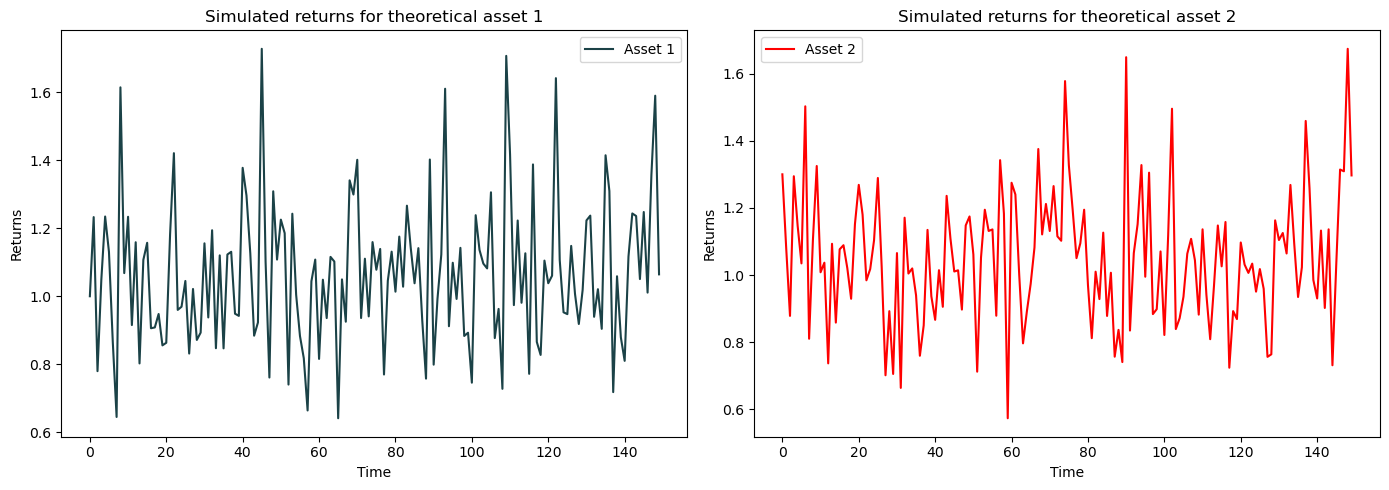

In [5]:
# Generate Simulated Log-Returns (similar to the structure you had)
def simulate_returns(mu, sigma_2, Sigma, num_data_points=364):
    # Ensure the covariance matrix is positive definite
    try:
        L = np.linalg.cholesky(Sigma)
    except np.linalg.LinAlgError:
        # Add a small jitter to the diagonal for numerical stability
        jitter = 1e-6
        Sigma += np.eye(Sigma.shape[0]) * jitter
        L = np.linalg.cholesky(Sigma)
        print(f"Added jitter to covariance matrix for Cholesky decomposition: {jitter}")
    
    # Generate independent standard normal variables
    z = np.random.normal(size=(num_data_points, len(mu)))
    
    # Initialize log-returns array
    log_returns = np.zeros((num_data_points, len(mu)))
    
    for t in range(num_data_points):
        # Generate correlated shocks
        correlated_shocks = L @ z[t]
        # Compute log-returns
        log_returns[t] = mu - 0.5 * sigma_2 + correlated_shocks
    
    # Exponentiate to get returns
    returns = np.exp(log_returns)
    return log_returns, returns

log_returns , returns = simulate_returns(mu, sigma_2, Sigma, num_data_points=k)

# Verify the mean and covariance of the log-returns
print("Empirical mean of log-returns: ", np.mean(log_returns, axis=0))
print("Empirical covariance of log-returns: \n", np.cov(log_returns.T))

# Verify the mean and covariance of the log-normal returns (this won't match the log-returns directly)
print("Empirical mean of returns: ", np.mean(returns, axis=0))
print("Empirical covariance of returns: \n", np.cov(returns.T))


# Output mean and covariance
# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# Plot for Asset 1
axs[0].plot(returns[:, 0], label='Asset 1')
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Returns')
axs[0].set_title('Simulated returns for theoretical asset 1')
axs[0].legend()

# Plot for Asset 2 with a different color
axs[1].plot(returns[:, 1], label='Asset 2', color='red')
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Returns')
axs[1].set_title('Simulated returns for theoretical asset 2')
axs[1].legend()
plt.tight_layout()
# theme.apply_transforms()
plt.show()

In [9]:
# Set print options
torch.set_printoptions(sci_mode=False, precision=4)
np.set_printoptions(suppress=True, precision=4)

# Limit PyTorch and NumPy to use a single thread per worker
torch.set_num_threads(1)
os.environ['OMP_NUM_THREADS'] = '1'
os.environ['MKL_NUM_THREADS'] = '1'

def get_hermite_nodes_weights(n_q):
    nodes_1d, weights_1d = hermgauss(n_q)
    # Adjust nodes and weights for the standard normal distribution
    nodes_1d = nodes_1d * np.sqrt(2)
    weights_1d = weights_1d / np.sqrt(np.pi)
    return nodes_1d, weights_1d

def get_multidimensional_nodes_weights(nodes_1d, weights_1d, D):
    nodes = list(itertools.product(nodes_1d, repeat=D))
    weights = list(itertools.product(weights_1d, repeat=D))
    nodes = np.array(nodes)
    weights = np.array(weights)
    weights = np.prod(weights, axis=1)
    return nodes, weights

def transform_nodes(nodes, mu, Sigma):
    L = np.linalg.cholesky(Sigma + jitter * np.eye(Sigma.shape[0]))
    transformed_nodes = nodes @ L.T + mu
    return transformed_nodes, L

# Define the GPR model with ARD
class GPRegressionModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(GPRegressionModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.MaternKernel(nu=1.5, ard_num_dims=train_x.shape[1]),
            jitter=1e-8  # Adding jitter for numerical stability
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

def train_gp_model(train_x, train_y):
    likelihood = gpytorch.likelihoods.GaussianLikelihood(
        noise_constraint=gpytorch.constraints.GreaterThan(1e-8)
    )
    model = GPRegressionModel(train_x, train_y, likelihood)
    model.train()
    likelihood.train()

    optimizer = torch.optim.Adam(model.parameters(), lr=0.05)
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    training_iterations = 250
    for i in range(training_iterations):
        optimizer.zero_grad()
        output = model(train_x)
        loss = -mll(output, train_y)
        loss.backward()
        optimizer.step()

    return model, likelihood

def utility(var, gamma):
    var = torch.clamp(var, min=1e-4)
    if gamma == 1:
        return torch.log(var)  # Log utility for gamma = 1
    else:
        return (var ** (1.0 - gamma)) / (1.0 - gamma)  # CRRA utility

def safe_utility(var, gamma):
    return utility(var, gamma)

def normalized_bond_holdings(xt, delta_plus, delta_minus, tau):
    # Compute bond holdings
    bt = 1.0 - torch.sum(xt - delta_minus + delta_plus) - torch.sum(tau * delta_plus) - torch.sum(tau * delta_minus)
    bt = torch.clamp(bt, min=0.0, max=1.0)
    return bt  # Scalar

def normalized_state_dynamics(xt, delta_plus, delta_minus, Rt, bt, Rf, tau):
    # Compute next period's portfolio value
    pi_t1 = bt * Rf + torch.sum((xt + delta_plus - delta_minus) * Rt, dim=1, keepdim=True)
    # Ensure pi_t1 is positive
    pi_t1 = torch.clamp(pi_t1, min=1e-8)
    # Compute next period's state
    xt1 = ((xt + delta_plus - delta_minus) * Rt) / pi_t1
    # Wealth is not tracked between periods
    Wt = torch.tensor(1.0, dtype=torch.float32)
    Wt1 = Wt * pi_t1
    return pi_t1, xt1, Wt1

def V_terminal(xT):
    terminal_utility = utility(1.0 - tau * torch.sum(xT, dim=-1), gamma)
    return terminal_utility  # Shape: [1]

def bellman_equation(
    vt_next_in,
    vt_next_out,
    xt,
    delta_plus,
    delta_minus,
    beta,
    gamma,
    tau,
    Rf,
    convex_hull=None,
    t=None,
    mu=None,
    Sigma=None,
    quadrature_nodes_weights=None
):
    """
    Computes the value function vt using the Bellman equation with Gauss-Hermite quadrature.
    """
    D = len(mu)
    assert xt.dim() == 2 and xt.size(0) == 1, f"xt must be [1, D], got {xt.shape}"
    assert delta_plus.dim() == 2 and delta_plus.size(0) == 1, f"delta_plus must be [1, D], got {delta_plus.shape}"
    assert delta_minus.dim() == 2 and delta_minus.size(0) == 1, f"delta_minus must be [1, D], got {delta_minus.shape}"

    # Compute bond holdings
    bt = normalized_bond_holdings(xt, delta_plus, delta_minus, tau)

    # Check if quadrature nodes and weights are provided; if not, compute them
    if quadrature_nodes_weights is None:
        n_q = 7  # Number of quadrature points per dimension (adjust as needed)
        nodes_1d, weights_1d = get_hermite_nodes_weights(n_q)
        nodes, weights = get_multidimensional_nodes_weights(nodes_1d, weights_1d, D)
        quadrature_nodes_weights = (nodes, weights)
    else:
        nodes, weights, _ = quadrature_nodes_weights  # Ignore L here

    # Transform nodes to account for covariance
    nodes = transform_nodes(nodes, mu, Sigma)[0]  # Shape: [n_q^D, D]

    # Convert to torch tensors
    nodes = torch.tensor(nodes, dtype=torch.float32)  # Shape: [n_q^D, D]
    weights = torch.tensor(weights, dtype=torch.float32)  # Shape: [n_q^D]

    # Compute Rt
    Rt = torch.exp(nodes)  # Since log_Rt ~ N(mu, Sigma), nodes are log_Rt

    # Reshape xt and delta_plus, delta_minus
    xt = xt.squeeze(0)  # [D]
    delta_plus = delta_plus.squeeze(0)  # [D]
    delta_minus = delta_minus.squeeze(0)  # [D]

    # Compute total holdings
    xt_total = xt + delta_plus - delta_minus  # [D]
    xt_total = xt_total.unsqueeze(0)  # [1, D]

    # Compute next period's wealth
    xtRt = xt_total * Rt  # [n_q^D, D]

    pi_t1 = bt * Rf + torch.sum(xtRt, dim=1)  # [n_q^D]

    # Ensure pi_t1 is positive
    pi_t1 = torch.clamp(pi_t1, min=1e-8)

    # Compute next period's state
    xt1 = xtRt / pi_t1.unsqueeze(1)  # [n_q^D, D]

    # Determine if next state is inside NTR
    with torch.no_grad():
        in_ntr = is_in_ntr(xt1, convex_hull, delta_plus.unsqueeze(0), delta_minus.unsqueeze(0), t=t)  # [n_q^D]

    # Evaluate the next period's value function
    vt_next_vals = torch.zeros(xt1.size(0), dtype=torch.float32)

    # Evaluate value functions for inside and outside NTR
    if isinstance(vt_next_in, gpytorch.models.ExactGP):
        vt_next_in.eval()
    if isinstance(vt_next_out, gpytorch.models.ExactGP):
        vt_next_out.eval()

    if in_ntr.any():
        xt1_in = xt1[in_ntr]  # [n_in, D]
        if isinstance(vt_next_in, gpytorch.models.ExactGP):
            with torch.no_grad():
                vt_next_val_in = vt_next_in(xt1_in).mean.detach().squeeze()  # [n_in]
        else:
            vt_next_val_in = V_terminal(xt1_in).squeeze()  # [n_in]
        vt_next_vals[in_ntr] = vt_next_val_in

    if (~in_ntr).any():
        xt1_out = xt1[~in_ntr]  # [n_out, D]
        if isinstance(vt_next_out, gpytorch.models.ExactGP):
            with torch.no_grad():
                vt_next_val_out = vt_next_out(xt1_out).mean.detach().squeeze()  # [n_out]
        else:
            vt_next_val_out = V_terminal(xt1_out).squeeze()  # [n_out]
        vt_next_vals[~in_ntr] = vt_next_val_out

    # Compute the current value function contributions
    vt_i = beta * (pi_t1 ** (1.0 - gamma)) * vt_next_vals  # [n_q^D]

    # Compute the expected value by summing over all quadrature points
    expected_vt = torch.sum(vt_i * weights)  # Scalar

    vt = expected_vt.unsqueeze(0)  # Shape: [1]

    return vt

def sample_state_points(D):
    """
    Samples points at the vertices, midpoints, and additional points of the state space simplex.
    """
    # Generate all combinations of 0 and 1 for D dimensions
    points = list(product([0.0, .95], repeat=D))
    
    # Add the midpoint
    midpoint = [0.475] * D
    points.append(tuple(midpoint))
    
    # Add additional points like [0.25, 0.75] and [0.75, 0.25] for 2D case
    for i, j in combinations(range(D), 2):
        point1 = [0.0] * D
        point2 = [0.0] * D
        point1[i] = 0.245
        point1[j] = 0.745
        point2[i] = 0.745
        point2[j] = 0.25
        points.append(tuple(point1))
        points.append(tuple(point2))
    
    # Filter out points where the sum exceeds 1
    valid_points = [point for point in points if sum(point) <= 1.0]
    
    return torch.tensor(valid_points, dtype=torch.float32)  # Shape: [num_points, D]

def sample_state_points_simplex(D, N, max_attempts=50):
    """
    Samples N random points from the D-dimensional simplex where the sum of components is <= 1.
    """
    sampled_points = []
    attempts = 0
    total_required = N

    while len(sampled_points) < N and attempts < max_attempts:
        # Sample more points than needed to increase chances of acceptance
        sample_size = (total_required - len(sampled_points)) * 2
        points = torch.rand(sample_size, D)
        # Filter points where the sum of components is <= 1
        valid_points = points[torch.sum(points, dim=1) <= 1.0]
        sampled_points.extend(valid_points.tolist())
        attempts += 1

    if len(sampled_points) < N:
        raise ValueError(f"Could not sample {N} points with sum <= 1 after {max_attempts} attempts.")

    # Convert to tensor and select the first N points
    sampled_points = torch.tensor(sampled_points[:N], dtype=torch.float32)
    return sampled_points  # Shape: [N, D]

def is_in_ntr(x, convex_hull, delta_plus=None, delta_minus=None, epsilon_ntr=5e-4, t=None):
    """
    Determines whether each point in x is inside the NTR.
    """
    if convex_hull is None:
        return torch.zeros(x.size(0), dtype=torch.bool, device=x.device)

    with torch.no_grad():
        # Extract convex hull equations and perform tensor operations
        equations_A = torch.tensor(convex_hull.equations[:, :-1], dtype=torch.float32)
        equations_b = torch.tensor(convex_hull.equations[:, -1], dtype=torch.float32)
        inequalities = torch.matmul(x, equations_A.T) + equations_b.unsqueeze(0)  # Shape: [n_points, num_constraints]
        epsilon = 1e-6
        in_convex_hull = torch.all(inequalities <= epsilon, dim=1)
        if delta_plus is not None and delta_minus is not None:
            delta = delta_plus - delta_minus
            delta_policy = torch.all(torch.abs(delta) < epsilon_ntr, dim=-1)  # Shape: [1]
            return torch.logical_or(in_convex_hull, delta_policy)  # Shape: [1]
        return in_convex_hull  # Shape: [n_points]

def MertonPoint(mu, Sigma, r, gamma):
    """
    Computes the Merton portfolio weights.

    Args:
        mu (np.array): Expected returns vector of risky assets.
        Sigma (np.array): Covariance matrix of asset returns.
        r (float): Risk-free rate.
        gamma (float): Coefficient of relative risk aversion.

    Returns:
        np.array: Optimal portfolio weights in risky assets.
    """
    Sigma_inv = np.linalg.inv(Sigma)
    mu_r = mu - r
    pi_star = (1 / gamma) * Sigma_inv.dot(mu_r)
    return pi_star

class PortfolioOptimization(cyipopt.Problem):
    def __init__(
        self,
        D,
        xt,
        vt_next_in,
        vt_next_out,
        t,
        T,
        beta,
        gamma,
        tau,
        Rf,
        mu,
        Sigma,
        convex_hull=None,
        include_consumption=False,
        ntr_mid_point=None,
        quadrature_nodes_weights=None  # Added parameter
    ):
        self.D = D
        self.xt = xt.detach().clone()  # Shape: [1, D]
        self.vt_next_in = vt_next_in
        self.vt_next_out = vt_next_out
        self.t = t
        self.T = T
        self.beta = beta
        self.gamma = gamma
        self.tau = tau
        self.Rf = Rf
        self.mu = mu
        self.Sigma = Sigma
        self.convex_hull = convex_hull
        self.include_consumption = include_consumption
        self.ntr_mid_point = ntr_mid_point
        self.quadrature_nodes_weights = quadrature_nodes_weights  # Store quadrature data

        if not isinstance(xt, torch.Tensor):
            print(f"XT IS NOT A TENSOR, xt type: {type(xt)}")

        # Number of variables: delta_plus, delta_minus
        self.n = 2 * D

        # Number of constraints: D constraints from xt + delta >= 0, and 3 scalar constraints
        self.m = D + 3

        # Variable bounds
        lb = np.zeros(self.n)
        ub = np.ones(self.n)

        # Constraint bounds
        cl = np.zeros(self.m)
        cu = np.full(self.m, np.inf)  # All constraints are inequalities (>= 0)

        super().__init__(n=self.n, m=self.m, problem_obj=self, lb=lb, ub=ub, cl=cl, cu=cu)

    def objective(self, params):
        """
        Objective function for the optimization problem.
        """
        # Convert params to a tensor
        params_tensor = torch.tensor(params, dtype=torch.float32)
        delta_plus = params_tensor[:self.D].unsqueeze(0)  # Shape: [1, D]
        delta_minus = params_tensor[self.D:2 * self.D].unsqueeze(0)  # Shape: [1, D]

        # Since we're not computing gradients here, wrap computations in torch.no_grad()
        with torch.no_grad():
            vt = bellman_equation(
                self.vt_next_in,
                self.vt_next_out,
                self.xt,
                delta_plus,
                delta_minus,
                self.beta,
                self.gamma,
                self.tau,
                self.Rf,
                self.convex_hull,
                self.t,
                mu=self.mu,
                Sigma=self.Sigma,
                quadrature_nodes_weights=self.quadrature_nodes_weights
            )
        if torch.isnan(vt).any() or torch.isinf(vt).any():
            raise ValueError("NaN or Inf detected in objective function!")      

        vt_scalar = vt.squeeze(0)
        return -vt_scalar.item()  # Only convert to scalar at the return statement

    def gradient(self, params):
        """
        Gradient of the objective function.
        """
        # Convert params to a tensor with gradient tracking
        params_tensor = torch.tensor(params, dtype=torch.float32, requires_grad=True)
        delta_plus = params_tensor[:self.D].unsqueeze(0)  # Shape: [1, D]
        delta_minus = params_tensor[self.D:2 * self.D].unsqueeze(0)  # Shape: [1, D]

        vt = bellman_equation(
            self.vt_next_in,
            self.vt_next_out,
            self.xt,
            delta_plus,
            delta_minus,
            self.beta,
            self.gamma,
            self.tau,
            self.Rf,
            self.convex_hull,
            self.t,
            mu=self.mu,
            Sigma=self.Sigma,
            quadrature_nodes_weights=self.quadrature_nodes_weights
        )

        # Compute gradients
        vt.backward()

        # Extract gradients
        grads = params_tensor.grad.detach().cpu().numpy()
        return -grads  # Return negative of the gradients

    def compute_constraints(self, params_tensor):
        """
        Compute the constraints for the optimization problem.
        """
        assert isinstance(params_tensor, torch.Tensor), f"params_tensor must be a torch.Tensor, got {type(params_tensor)}"
        assert params_tensor.dim() == 1 and params_tensor.size(0) == self.n, f"params_tensor must be [2*D], got {params_tensor.shape}"

        # Extract delta_plus and delta_minus from the parameter vector
        delta_plus = params_tensor[:self.D].unsqueeze(0)  # Shape: [1, D]
        delta_minus = params_tensor[self.D:2 * self.D].unsqueeze(0)  # Shape: [1, D]
        delta = delta_plus - delta_minus  # Shape: [1, D]
        xt = self.xt  # Shape: [1, D]

        # Constraint 1: xt + delta >= 0 (element-wise for each asset)
        constraints_xt_delta = (xt + delta).squeeze(0)  # Shape: [D]

        # Constraint 2: bond holdings bt >= 0
        bt = normalized_bond_holdings(
            xt,             # [1, D]
            delta_plus,     # [1, D]
            delta_minus,    # [1, D]
            self.tau
        )  # Scalar

        # Constraint 3: sum(xt + delta) <= 1
        sum_allocations = torch.sum(xt + delta)  # Scalar
        constraint_sum_leq_1 = 1.0 - sum_allocations  # Scalar

        # Constraint 4: sum(xt + delta) >= 0 (redundant but included)
        constraint_sum_geq_0 = sum_allocations  # Scalar

        # Concatenate all constraints into a single tensor
        constraints_tensor = torch.cat([
            constraints_xt_delta,                 # Shape: [D] (asset allocation constraints)
            bt.unsqueeze(0),                      # Shape: [1] (bond holdings constraint)
            constraint_sum_leq_1.unsqueeze(0),    # Shape: [1] (sum allocation <= 1)
            constraint_sum_geq_0.unsqueeze(0)     # Shape: [1] (sum allocation >= 0)
        ])  # Shape: [D + 3]

        # Ensure the tensor does not have NaNs or infinities
        constraints_tensor = torch.nan_to_num(constraints_tensor, nan=1e16, posinf=1e16, neginf=-1e16)
        return constraints_tensor

    def constraints_method(self, params):
        """
        Computes the constraints for the optimization problem.
        """
        try:
            # Convert NumPy array to PyTorch tensor
            params_tensor = torch.tensor(params, dtype=torch.float32)
            assert isinstance(params_tensor, torch.Tensor), f"params_tensor must be a torch.Tensor, got {type(params_tensor)}"
            assert params_tensor.dim() == 1 and params_tensor.size(0) == self.n, f"params_tensor must be [2*D], got {params_tensor.shape}"

            # Compute constraints using PyTorch tensors
            constraints_tensor = self.compute_constraints(params_tensor)

            # Convert constraints back to NumPy array for IPOPT
            constraints_array = constraints_tensor.detach().cpu().numpy()
            return constraints_array
        except Exception as e:
            logging.error(f"Error in constraints method: {e}", exc_info=True)
            # Return large positive values to indicate infeasibility
            return np.full(self.m, 1e16)   

    def jacobian(self, params):
        """
        Computes the Jacobian matrix of the constraints.
        """
        D = self.D
        tau = self.tau
        # Initialize Jacobian matrix with zeros
        jac = np.zeros((self.m, self.n))

        # Asset Allocation Constraints
        for d in range(D):
            # Derivatives with respect to delta_plus
            jac[d, d] = 1.0
            # Derivatives with respect to delta_minus
            jac[d, D + d] = -1.0

        # Bond Holdings Constraint (g_D)
        for d in range(D):
            jac[D, d] = -1.0 - tau  # delta_plus derivatives
            jac[D, D + d] = 1.0 - tau  # delta_minus derivatives

        # Sum Allocation Constraints (g_{D+1} and g_{D+2})
        for d in range(D):
            # Constraint g_{D+1}: 1 - sum(x + delta) >= 0
            jac[D + 1, d] = -1.0
            jac[D + 1, D + d] = 1.0

            # Constraint g_{D+2}: sum(x + delta) >= 0
            jac[D + 2, d] = 1.0
            jac[D + 2, D + d] = -1.0

        # Flatten the Jacobian in column-major order
        jacobian_flat = jac.flatten(order='C')
        return jacobian_flat

    # Assign the constraints method to comply with cyipopt's requirements
    constraints = constraints_method

def solve_bellman_with_ipopt(
    D, xt, vt_next_in, vt_next_out, t, T, beta, gamma, tau, Rf, mu, Sigma,
    convex_hull=None, quadrature_nodes_weights=None, include_consumption=False, num_starts=5, drop_tolerance=0.2
):
    best_solution = None
    best_info = None
    best_obj_val = float('-inf')
    failed_attempts = 0
    max_failed_attempts = int(num_starts)

    logging.info(f"Solving Bellman equation for xt: {xt}")
    # Ensure xt has a batch dimension
    if xt.dim() == 1:
        xt = xt.unsqueeze(0)  # Shape: [1, D]

    def generate_feasible_initial_guess(xt, D, tau, include_consumption=False, max_attempts=1000):
        attempts = 0
        while attempts < max_attempts:
            # Existing conditions for specific xt values
            if torch.allclose(xt, torch.tensor([[0.0, 0.0]], dtype=torch.float32)):
                delta_plus = torch.rand(D, dtype=torch.float32) * 0.125  # Shape: [D]
                delta_minus = torch.zeros(D, dtype=torch.float32)       # Shape: [D]
            elif torch.allclose(xt, torch.tensor([[1.0, 0.0]], dtype=torch.float32)):
                delta_plus = torch.tensor([0.0, 0.09], dtype=torch.float32)
                delta_minus = torch.tensor([0.175, 0.0], dtype=torch.float32)
            elif torch.allclose(xt, torch.tensor([[0.0, 1.0]], dtype=torch.float32)):
                delta_plus = torch.tensor([0.09, 0.0], dtype=torch.float32)
                delta_minus = torch.tensor([0.0, 0.175], dtype=torch.float32)
            elif torch.allclose(xt, torch.tensor([[0.5, 0.5]], dtype=torch.float32)):
                delta_plus = torch.tensor([0.0, 0.0], dtype=torch.float32)
                delta_minus = torch.tensor([0.075, 0.075], dtype=torch.float32)
            else:
                # Random initial guesses within feasible bounds
                delta_plus = (torch.rand(D, dtype=torch.float32) * (1 - xt) * 0.9).squeeze(0)
                delta_minus = (torch.rand(D, dtype=torch.float32) * xt * 0.9).squeeze(0)
            
            delta_plus = torch.clamp(delta_plus, 0, 1).unsqueeze(0)  # Shape: [1, D]
            delta_minus = torch.clamp(delta_minus, 0, 1).unsqueeze(0)  # Shape: [1, D]
            delta = delta_plus - delta_minus

            transaction_costs = tau * torch.sum(delta_plus + delta_minus)
            bt = 1.0 - torch.sum(xt + delta) - transaction_costs
            if bt < 0:
                attempts += 1
                continue

            x_plus_delta = xt + delta  # [1, D] + [1, D] -> [1, D]
            if torch.any(x_plus_delta < 0) or (1.0 - torch.sum(x_plus_delta) < 0):
                attempts += 1
                continue

            # Ensure that the initial guess is returned as a 1D tensor of length 2*D
            initial_guess = torch.cat([delta_plus, delta_minus], dim=1).flatten()  # Shape: [2 * D]
            assert initial_guess.shape[0] == 2 * D, f"Initial guess has incorrect length: {initial_guess.shape[0]}"
            return initial_guess  # Return a 1D tensor

        raise ValueError("Failed to generate a feasible initial guess after maximum attempts")

    # Loop through multiple starting points
    for start_idx in range(num_starts):
        try:
            initial_guess = generate_feasible_initial_guess(xt, D, tau, include_consumption=False)
            logging.debug(f"Start {start_idx}: Initial guess generated.")
        except ValueError as e:
            logging.warning(f"Start {start_idx}: {e}")
            failed_attempts += 1
            if failed_attempts > max_failed_attempts:
                logging.error(f"Exceeded maximum allowed failed attempts: {max_failed_attempts}")
                return None, None, None, None, None
            continue

        try:
            # Create the optimization problem
            prob = PortfolioOptimization(
                D,
                xt,
                vt_next_in,
                vt_next_out,
                t,
                T,
                beta,
                gamma,
                tau,
                Rf,
                mu,
                Sigma=Sigma,
                convex_hull=convex_hull,
                ntr_mid_point=None,
                include_consumption=include_consumption,
                quadrature_nodes_weights=quadrature_nodes_weights  # Pass quadrature data
            )

            # Set IPOPT options
            prob.add_option("tol", 1e-8)
            prob.add_option("max_iter", 1000)
            prob.add_option("linear_solver", "mumps")  # Use an efficient sparse solver
            prob.add_option("warm_start_init_point", "yes")
            prob.add_option("nlp_scaling_method", "gradient-based")
            prob.add_option("print_level", 2)
            prob.add_option("honor_original_bounds", "yes")
            prob.add_option("mu_strategy", "adaptive")        # Adaptive step size strategy
            prob.add_option("mu_oracle", "quality-function")  # Control step quality
            prob.add_option("hessian_approximation", 'limited-memory')  # Quasi-Newton Approximation
            prob.add_option("derivative_test", "none")
            prob.add_option("max_cpu_time", 360.0)

            # Convert initial_guess to NumPy array
            initial_guess_np = initial_guess.cpu().numpy()
            assert len(initial_guess_np) == 2 * D, f"Initial guess length {len(initial_guess_np)} != {2 * D}"
            solution, info = prob.solve(initial_guess_np)

            # Check if the solution is valid
            if solution is None:
                logging.warning(f"Start {start_idx}: Solver returned None solution.")
                failed_attempts += 1
                if failed_attempts > max_failed_attempts:
                    logging.error(f"Exceeded maximum allowed failed attempts: {max_failed_attempts}")
                    return None, None, None, None, None
                continue

            if len(solution) != 2 * D:
                print(f"wrong length, solution is: {solution}")
                logging.warning(f"Start {start_idx}: Unexpected solution length: {len(solution)}. Expected: {2 * D}")
                failed_attempts += 1
                if failed_attempts > max_failed_attempts:
                    logging.error(f"Exceeded maximum allowed failed attempts: {max_failed_attempts}")
                    return None, None, None, None, None
                continue

            # Check if this solution is better than the current best
            if info['status'] == 0 and (best_solution is None or info['obj_val'] > best_obj_val):
                best_solution = solution
                best_info = info
                best_obj_val = info['obj_val']
                logging.info(f"Start {start_idx}: New best solution found with obj_val: {best_obj_val}")

        except Exception as e:
            print(f"Optimization failed for start {start_idx}: {e}")
            logging.error(f"Optimization failed for start {start_idx}: {e}", exc_info=True)
            failed_attempts += 1
            if failed_attempts > max_failed_attempts:
                print(f"Exceeded maximum allowed failed attempts: {max_failed_attempts}")
                logging.error(f"Exceeded maximum allowed failed attempts: {max_failed_attempts}")
                return None, None, None, None, None
            continue

    if best_solution is None:
        print(f"No optimizer solution found for point {xt}!")
        logging.error(f"No optimizer solution found for point {xt}!")
        return None, None, None, None, None

    try:
        # After finding the best solution, extract the variables
        idx = 0
        delta_plus_opt = best_solution[idx : idx + D]  # Shape: [D]
        delta_minus_opt = best_solution[idx + D : idx + 2 * D]  # Shape: [D]
        delta_opt = delta_plus_opt - delta_minus_opt  # Shape: [D]

        # Convert delta_plus_opt and delta_minus_opt to tensors and reshape to [1, D]
        delta_plus_tensor = torch.tensor(delta_plus_opt, dtype=torch.float32).unsqueeze(0)  # [1, D]
        delta_minus_tensor = torch.tensor(delta_minus_opt, dtype=torch.float32).unsqueeze(0)  # [1, D]

        # Compute omega_i_t and bond holdings (bt)
        omega_i_t = xt.cpu().numpy() + delta_opt  # [1, D] + [D] -> [1, D]
        bt = normalized_bond_holdings(
            xt, delta_plus_tensor, delta_minus_tensor, tau
        ).item()
        
        torch.set_printoptions(sci_mode=False, precision=4)
        np.set_printoptions(suppress=True, precision=4)
        
        del prob
        torch.cuda.empty_cache()  # If using CUDA
        
        return delta_plus_opt, delta_minus_opt, delta_opt, omega_i_t, bt
    except Exception as e:
        logging.error(f"Error processing best solution: {e}", exc_info=True)
        return None, None, None, None, None

def approximate_ntr(vt_next_in, vt_next_out, D, t, T, beta, gamma, tau, Rf, mu, Sigma):
    """
    Approximates the Non-Trading Region (NTR) at time t.
    """
    # Step 1: Sample state points at vertices and midpoints
    tilde_X_t = sample_state_points(D)  # Shape: [num_points, D]
    N = tilde_X_t.size(0)
    tilde_omega_t = []

    for i in range(N):
        tilde_x_i_t = tilde_X_t[i:i+1]  # Shape: [1, D]
        delta_plus, delta_minus, delta, omega_i_t, b_t = solve_bellman_with_ipopt(
            D, tilde_x_i_t.squeeze(0), vt_next_in, vt_next_out, t, T, beta, gamma, tau, Rf, mu, Sigma
        )
        if delta_plus is None:
            print(f"Delta is None for point {tilde_x_i_t}")
        if delta_plus is not None:
            # Reshape delta to [1, D] for consistency
            delta = torch.tensor(delta, dtype=torch.float32).unsqueeze(0)  # [1, D]
            tilde_omega_i_t = (tilde_x_i_t + delta)  # Shape: [1, D]
            tilde_omega_t.append(tilde_omega_i_t.squeeze(0).detach().numpy())  # [D]
    
    # Construct convex hull
    if len(tilde_omega_t) >= D + 1:
        tilde_omega_t = np.vstack(tilde_omega_t)  # Shape: [num_points, D]
        convex_hull = ConvexHull(tilde_omega_t)
    else:
        convex_hull = None

    return tilde_omega_t, convex_hull

def bayesian_active_learning(model, likelihood, state_space, num_new_points=10):
    """
    Applies Bayesian Active Learning to select new points with the highest uncertainty.
    """
    model.eval()
    likelihood.eval()

    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        pred_dist = model(state_space)
        variance = pred_dist.variance  # Shape: [num_points]

    # Ensure state_space and variance are tensors
    state_space = torch.tensor(state_space) if not isinstance(state_space, torch.Tensor) else state_space
    variance = torch.tensor(variance) if not isinstance(variance, torch.Tensor) else variance

    # Adjust num_new_points if it is greater than the length of variance
    num_new_points = min(num_new_points, len(variance))

    # Get the top indices based on variance
    _, top_var_indices = torch.topk(variance, num_new_points)

    # Select new samples from state_space using the top indices
    new_samples = state_space[top_var_indices]  # Shape: [num_new_points, D]

    return new_samples

def process_point(
    x_i_t,
    quadrature_nodes_weights,
    V_t_plus1_in,
    V_t_plus1_out,
    t,
    T,
    beta,
    gamma,
    tau,
    Rf,
    mu,
    Sigma,
    NTR_t,
    D
):
    """
    Processes a single state point by solving the optimization problem.

    Args:
        x_i_t (torch.Tensor): Current state vector. Shape: [D]
        quadrature_nodes_weights (tuple): Quadrature nodes and weights.
        V_t_plus1_in (gpytorch.models.ExactGP or callable): Value function for inside NTR.
        V_t_plus1_out (gpytorch.models.ExactGP or callable): Value function for outside NTR.
        t (int): Current time step.
        T (int): Total number of time periods.
        beta (float): Discount factor.
        gamma (float): Coefficient of relative risk aversion.
        tau (float): Transaction cost.
        Rf (float): Risk-free rate factor.
        mu (np.array): Mean vector for asset returns.
        Sigma (np.array): Covariance matrix for asset returns.
        NTR_t (scipy.spatial.ConvexHull or None): Convex hull defining the NTR.
        D (int): Number of assets.

    Returns:
        tuple or None: (x_i_t, v_i_t_value, in_ntr_value) if successful, else None.
    """
    logging.info(f"Step 2c: Solve optimization problem for point {x_i_t}")

    # Solve the optimization problem
    delta_plus, delta_minus, delta_opt, omega_i_t, bt = solve_bellman_with_ipopt(
        D, x_i_t, V_t_plus1_in, V_t_plus1_out, t, T, beta, gamma, tau, Rf, mu, Sigma,
        convex_hull=NTR_t,
        quadrature_nodes_weights=quadrature_nodes_weights
    )

    if delta_plus is None:
        logging.warning(f"Step 2c: Optimization failed for point {x_i_t}. Skipping.")
        return None  # Indicate failure

    print(f"Best solution found. Point {x_i_t}, Delta+: {delta_plus}, Delta-: {delta_minus}, Delta: {delta_opt}, Omega: {omega_i_t}, bt: {np.round(bt, 4)}")

    logging.info(f"Time: {t}, Point: {x_i_t}, Delta+: {delta_plus}, Delta-: {delta_minus}, Delta: {delta_opt}, Omega: {omega_i_t}, bt: {bt}")

    # Compute value using the Bellman equation
    x_i_t_tensor = x_i_t.unsqueeze(0)  # [1, D]
    delta_plus_tensor = torch.tensor(delta_plus, dtype=torch.float32).unsqueeze(0)  # [1, D]
    delta_minus_tensor = torch.tensor(delta_minus, dtype=torch.float32).unsqueeze(0)  # [1, D]
    v_i_t = bellman_equation(
        V_t_plus1_in, V_t_plus1_out, x_i_t_tensor, delta_plus_tensor, delta_minus_tensor,
        beta, gamma, tau, Rf, convex_hull=NTR_t, t=t, mu=mu, Sigma=Sigma,
        quadrature_nodes_weights=quadrature_nodes_weights
    )

    # Determine if the point is inside the NTR
    with torch.no_grad():
        in_ntr = is_in_ntr(
            x_i_t_tensor, NTR_t, delta_plus_tensor, delta_minus_tensor, t=t
        )

    # Prepare the result
    result = (x_i_t, v_i_t.item(), in_ntr.item())

    # Clean up
    del delta_plus_tensor, delta_minus_tensor, v_i_t
    torch.cuda.empty_cache()

    return result

# Main computation
def main():
    # Define parameters
    D = 2  # Number of assets
    T =  10  # Number of time periods
    N = 150  # Number of state points to sample
    beta = 0.975
    gamma = 3.5
    tau = 0.02
    r = 0.02
    Rf = np.exp(r)
    mu = np.array([0.06, 0.06])
    Sigma = np.array([[0.16, 0.00], [0.00, 0.16]])

    # Initialize value function V
    V = [[None, None] for _ in range(T + 1)]

    # Set terminal value function
    V[T][0] = V_terminal  # For inside NTR
    V[T][1] = V_terminal  # For outside NTR

    NTRs = [None for _ in range(T)]  # Store NTRs for each period

    for t in reversed(range(T)):
        print(f"Time step {t}")

        # Generate quadrature nodes and weights using helper functions
        nodes_1d, weights_1d = get_hermite_nodes_weights(n_q=7)
        nodes, weights = get_multidimensional_nodes_weights(nodes_1d, weights_1d, D=D)
        transformed_nodes, L = transform_nodes(nodes, mu, Sigma)  # Shape: [n_q^D, D], [D, D]
        quadrature_nodes_weights = (transformed_nodes, weights, L)  # Include L for scaling

        # Step 2a: Approximate NTR
        print("Step 2a: Approximate NTR")
        tilde_omega_t, convex_hull = approximate_ntr(
            V[t + 1][0], V[t + 1][1], D, t, T, beta, gamma, tau, Rf, mu, Sigma
        )
        NTRs[t] = convex_hull

        # Step 2b: Sample state points
        print("Step 2b: Sample state points")
        X_t = sample_state_points_simplex(D, N)  # Shape: [N, D]
        data_in = []
        data_out = []

        # Step 2c: Parallel processing of points
        num_jobs = 4  # NEVER use all cores. num_jobs should be <= N
        results = Parallel(n_jobs=num_jobs, backend='threading')(
            delayed(process_point)(
                x_i_t,
                quadrature_nodes_weights=quadrature_nodes_weights,
                V_t_plus1_in=V[t + 1][0],
                V_t_plus1_out=V[t + 1][1],
                t=t,
                T=T,
                beta=beta,
                gamma=gamma,
                tau=tau,
                Rf=Rf,
                mu=mu,
                Sigma=Sigma,
                NTR_t=NTRs[t],
                D=D
            ) for x_i_t in X_t
        )

        # Process the results
        for result in results:
            if result is None:
                continue
            x_i_t, v_i_t_value, in_ntr_value = result
            if in_ntr_value:
                data_in.append((x_i_t, v_i_t_value))
            else:
                data_out.append((x_i_t, v_i_t_value))          

        # Step 2e: Train GPR models for inside and outside NTR
        print("Step 2e: Train GPR models for inside and outside NTR")
        if data_in:
            train_x_in = torch.stack([d[0] for d in data_in])  # [num_in, D]
            train_y_in = torch.tensor([d[1] for d in data_in], dtype=torch.float32)  # [num_in]
            model_in, likelihood_in = train_gp_model(train_x_in, train_y_in)
            V[t][0] = model_in
            print(f"train gp model_in done ")
            # Apply Bayesian Active Learning to add new high-uncertainty points
            new_samples_in = bayesian_active_learning(
                model_in, likelihood_in, train_x_in, num_new_points=int(0.2 * N)
            )  # Use train_x_in for uncertainty
            for sample in new_samples_in:
                # sample is [D], reshape to [1, D]
                sample_tensor = sample.unsqueeze(0)  # [1, D]
                delta_plus, delta_minus, delta, omega_i_t, b_t = solve_bellman_with_ipopt(
                    D, sample, V[t + 1][0], V[t + 1][1], t, T, beta, gamma, tau, Rf, mu, Sigma,
                    convex_hull=NTRs[t],
                    quadrature_nodes_weights=quadrature_nodes_weights  # Pass quadrature data
                )
                if delta_plus is None:
                    continue
                # Reshape for bellman_equation
                delta_plus_tensor_new = torch.tensor(delta_plus, dtype=torch.float32).unsqueeze(0)  # [1, D]
                delta_minus_tensor_new = torch.tensor(delta_minus, dtype=torch.float32).unsqueeze(0)  # [1, D]
                v_i_t_new = bellman_equation(
                    V[t + 1][0], V[t + 1][1], sample_tensor, 
                    delta_plus_tensor_new, delta_minus_tensor_new, beta, gamma, tau, Rf, 
                    convex_hull=NTRs[t],
                    t=t,
                    mu=mu,
                    Sigma=Sigma,
                    quadrature_nodes_weights=quadrature_nodes_weights  # Pass quadrature data
                )
                data_in.append((sample.detach(), v_i_t_new.item()))

                # Clear computational graph
                del delta_plus_tensor_new, delta_minus_tensor_new, v_i_t_new
                torch.cuda.empty_cache()  # If using CUDA

            print(f"new_samples_in done")

        if data_out:
            train_x_out = torch.stack([d[0] for d in data_out])  # [num_out, D]
            train_y_out = torch.tensor([d[1] for d in data_out], dtype=torch.float32)  # [num_out]
            model_out, likelihood_out = train_gp_model(train_x_out, train_y_out)
            V[t][1] = model_out
            print(f"train gp model_out done ")

            # Apply Bayesian Active Learning to add new high-uncertainty points
            new_samples_out = bayesian_active_learning(
                model_out, likelihood_out, train_x_out, num_new_points=int(0.2 * N)
            )  # Use train_x_out for uncertainty
            for sample in new_samples_out:
                # sample is [D], reshape to [1, D]
                sample_tensor = sample.unsqueeze(0)  # [1, D]
                delta_plus, delta_minus, delta, omega_i_t, b_t = solve_bellman_with_ipopt(
                    D, sample, V[t + 1][0], V[t + 1][1], t, T, beta, gamma, tau, Rf, mu, Sigma,
                    convex_hull=NTRs[t],
                    quadrature_nodes_weights=quadrature_nodes_weights  # Pass quadrature data
                )
                if delta_plus is None:
                    continue
                # Reshape for bellman_equation
                delta_plus_tensor_new = torch.tensor(delta_plus, dtype=torch.float32).unsqueeze(0)  # [1, D]
                delta_minus_tensor_new = torch.tensor(delta_minus, dtype=torch.float32).unsqueeze(0)  # [1, D]
                v_i_t_new = bellman_equation(
                    V[t + 1][0], V[t + 1][1], sample_tensor, 
                    delta_plus_tensor_new, delta_minus_tensor_new, beta, gamma, tau, Rf, 
                    convex_hull=NTRs[t],
                    t=t,
                    mu=mu,
                    Sigma=Sigma,
                    quadrature_nodes_weights=quadrature_nodes_weights  # Pass quadrature data
                )
                data_out.append((sample.detach(), v_i_t_new.item()))
                # Clear computational graph
                del delta_plus_tensor_new, delta_minus_tensor_new, v_i_t_new
                torch.cuda.empty_cache()  # If using CUDA
            print(f"new_samples_out done")
        # Retrain GPR models with the new data
        if data_in:
            train_x_in = torch.stack([d[0] for d in data_in])  # [num_in, D]
            train_y_in = torch.tensor([d[1] for d in data_in], dtype=torch.float32)  # [num_in]
            model_in, likelihood_in = train_gp_model(train_x_in, train_y_in)
            V[t][0] = model_in
            print(f"retrain in done")

        if data_out:
            train_x_out = torch.stack([d[0] for d in data_out])  # [num_out, D]
            train_y_out = torch.tensor([d[1] for d in data_out], dtype=torch.float32)  # [num_out]
            model_out, likelihood_out = train_gp_model(train_x_out, train_y_out)
            V[t][1] = model_out
            print(f"retrain out done")

        # Clear previous value functions to free memory
        if t < T - 1:
            if V[t+1][0] is not None:
                del V[t+1]

        # Clear other variables if necessary
        del data_in, data_out, train_x_in, train_y_in
        torch.cuda.empty_cache()  # If using CUDA

if __name__ == "__main__":
    main()

Time step 9
Step 2a: Approximate NTR
Step 2b: Sample state points
Best solution found. Point tensor([0.5154, 0.4077]), Delta+: [0. 0.], Delta-: [0. 0.], Delta: [0. 0.], Omega: [[0.5154 0.4077]], bt: 0.0769
Best solution found. Point tensor([0.1930, 0.0049]), Delta+: [0.1812 0.3693], Delta-: [0. 0.], Delta: [0.1812 0.3693], Omega: [[0.3741 0.3741]], bt: 0.2407
Best solution found. Point tensor([0.2647, 0.0307]), Delta+: [0.1102 0.3441], Delta-: [0. 0.], Delta: [0.1102 0.3441], Omega: [[0.3749 0.3749]], bt: 0.2412
Best solution found. Point tensor([0.0826, 0.7933]), Delta+: [0.1828 0.    ], Delta-: [0.     0.0636], Delta: [ 0.1828 -0.0636], Omega: [[0.2654 0.7297]], bt: 0.0
Best solution found. Point tensor([0.5522, 0.3117]), Delta+: [0.     0.0628], Delta-: [0. 0.], Delta: [0.     0.0628], Omega: [[0.5522 0.3745]], bt: 0.072
Best solution found. Point tensor([0.0547, 0.8703]), Delta+: [0.2101 0.    ], Delta-: [0.     0.1421], Delta: [ 0.2101 -0.1421], Omega: [[0.2648 0.7282]], bt: 0.0
B

KeyboardInterrupt: 

Best solution found. Point tensor([0.8570, 0.0797]), Delta+: [0.     0.1853], Delta-: [0.1282 0.    ], Delta: [-0.1282  0.1853], Omega: [[0.7287 0.265 ]], bt: 0.0
Best solution found. Point tensor([0.1470, 0.3285]), Delta+: [0.2293 0.0478], Delta-: [0. 0.], Delta: [0.2293 0.0478], Omega: [[0.3762 0.3762]], bt: 0.242
Best solution found. Point tensor([0.7617, 0.1579]), Delta+: [0.     0.1081], Delta-: [0.0304 0.    ], Delta: [-0.0304  0.1081], Omega: [[0.7313 0.2659]], bt: 0.0
Best solution found. Point tensor([0.2167, 0.7466]), Delta+: [0.0496 0.    ], Delta-: [0.     0.0142], Delta: [ 0.0496 -0.0142], Omega: [[0.2663 0.7324]], bt: 0.0


In [22]:
import torch
import numpy as np
import itertools
from itertools import product, combinations
from scipy.special import roots_hermite as hermgauss
from scipy.spatial import ConvexHull
import cyipopt
import gpytorch
from joblib import Parallel, delayed
import logging
import os

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(levelname)s:%(message)s')

# Set print options
torch.set_printoptions(sci_mode=False, precision=4)
np.set_printoptions(suppress=True, precision=4)

# Limit PyTorch and NumPy to use a single thread per worker
torch.set_num_threads(1)
os.environ['OMP_NUM_THREADS'] = '1'
os.environ['MKL_NUM_THREADS'] = '1'


def get_hermite_nodes_weights(n_q):
    nodes_1d, weights_1d = hermgauss(n_q)
    # Adjust nodes and weights for the standard normal distribution
    nodes_1d = nodes_1d * np.sqrt(2)
    weights_1d = weights_1d / np.sqrt(np.pi)
    return nodes_1d, weights_1d


def get_multidimensional_nodes_weights(nodes_1d, weights_1d, D):
    nodes = list(itertools.product(nodes_1d, repeat=D))
    weights = list(itertools.product(weights_1d, repeat=D))
    nodes = np.array(nodes)
    weights = np.array(weights)
    weights = np.prod(weights, axis=1)
    return nodes, weights


def transform_nodes(nodes, mu, Sigma, jitter=1e-8):
    """
    Transforms standard normal quadrature nodes to match the specified mean and covariance.

    Args:
        nodes (np.array): Quadrature nodes. Shape: [num_points, D]
        mu (np.array): Mean vector. Shape: [D]
        Sigma (np.array): Covariance matrix. Shape: [D, D]
        jitter (float): Small value to add to the diagonal for numerical stability.

    Returns:
        transformed_nodes (np.array): Transformed nodes. Shape: [num_points, D]
        L (np.array): Cholesky factor of the adjusted covariance matrix. Shape: [D, D]
    """
    try:
        L = np.linalg.cholesky(Sigma + jitter * np.eye(Sigma.shape[0]))
    except np.linalg.LinAlgError:
        raise ValueError("Covariance matrix is not positive definite even after adding jitter.")
    transformed_nodes = nodes @ L.T + mu
    return transformed_nodes, L


# Define the GPR model with ARD
class GPRegressionModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(GPRegressionModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.MaternKernel(nu=1.5, ard_num_dims=train_x.shape[1]),
            jitter=1e-8  # Adding jitter for numerical stability
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


def train_gp_model(train_x, train_y):
    """
    Trains a Gaussian Process Regression model.

    Args:
        train_x (torch.Tensor): Training inputs. Shape: [num_samples, D]
        train_y (torch.Tensor): Training targets. Shape: [num_samples]

    Returns:
        model (GPRegressionModel): Trained GP model.
        likelihood (gpytorch.likelihoods.GaussianLikelihood): Associated likelihood.
    """
    likelihood = gpytorch.likelihoods.GaussianLikelihood(
        noise_constraint=gpytorch.constraints.GreaterThan(1e-8)
    )
    model = GPRegressionModel(train_x, train_y, likelihood)
    model.train()
    likelihood.train()

    optimizer = torch.optim.Adam(model.parameters(), lr=0.05)
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    training_iterations = 250
    for i in range(training_iterations):
        optimizer.zero_grad()
        output = model(train_x)
        loss = -mll(output, train_y)
        loss.backward()
        optimizer.step()

    return model, likelihood


def utility(var, gamma):
    """
    Computes CRRA utility.

    Args:
        var (torch.Tensor): Variable to compute utility for.
        gamma (float): Coefficient of relative risk aversion.

    Returns:
        torch.Tensor: Utility values.
    """
    var = torch.clamp(var, min=1e-4)
    if gamma == 1:
        return torch.log(var)  # Log utility for gamma = 1
    else:
        return (var ** (1.0 - gamma)) / (1.0 - gamma)  # CRRA utility


def normalized_bond_holdings(xt, delta_plus, delta_minus, tau):
    """
    Computes normalized bond holdings.

    Args:
        xt (torch.Tensor): Current holdings. Shape: [1, D]
        delta_plus (torch.Tensor): Adjustments (increases). Shape: [1, D]
        delta_minus (torch.Tensor): Adjustments (decreases). Shape: [1, D]
        tau (float): Transaction cost rate.

    Returns:
        torch.Tensor: Bond holdings. Shape: [1]
    """
    bt = 1.0 - torch.sum(xt + delta_plus - delta_minus) - torch.sum(tau * (delta_plus + delta_minus))
    bt = torch.clamp(bt, min=0.0, max=1.0)
    return bt  # Scalar


def normalized_state_dynamics(xt, delta_plus, delta_minus, Rt, bt, Rf, tau):
    """
    Computes next period's state dynamics.

    Args:
        xt (torch.Tensor): Current holdings. Shape: [1, D]
        delta_plus (torch.Tensor): Adjustments (increases). Shape: [1, D]
        delta_minus (torch.Tensor): Adjustments (decreases). Shape: [1, D]
        Rt (torch.Tensor): Returns matrix. Shape: [n_q^D, D]
        bt (torch.Tensor): Bond holdings. Shape: [1]
        Rf (float): Risk-free rate factor.
        tau (float): Transaction cost rate.

    Returns:
        tuple: (pi_t1, xt1, Wt1)
    """
    # Compute next period's portfolio value
    pi_t1 = bt * Rf + torch.sum((xt + delta_plus - delta_minus) * Rt, dim=1, keepdim=True)
    # Ensure pi_t1 is positive
    pi_t1 = torch.clamp(pi_t1, min=1e-8)
    # Compute next period's state
    xt1 = ((xt + delta_plus - delta_minus) * Rt) / pi_t1
    # Wealth is not tracked between periods
    Wt = torch.tensor(1.0, dtype=torch.float32)
    Wt1 = Wt * pi_t1
    return pi_t1, xt1, Wt1


def V_terminal(xT, tau, gamma):
    """
    Terminal value function.

    Args:
        xT (torch.Tensor): Holdings at terminal time. Shape: [n_samples, D]
        tau (float): Transaction cost rate.
        gamma (float): Coefficient of relative risk aversion.

    Returns:
        torch.Tensor: Terminal utility values. Shape: [n_samples]
    """
    terminal_utility = utility(1.0 - tau * torch.sum(xT, dim=-1), gamma)
    return terminal_utility  # Shape: [n_samples]


def bellman_equation(
    vt_next_in,
    vt_next_out,
    xt,
    delta_plus,
    delta_minus,
    beta,
    gamma,
    tau,
    Rf,
    convex_hull=None,
    t=None,
    mu=None,
    Sigma=None,
    quadrature_nodes_weights=None
):
    """
    Computes the value function vt using the Bellman equation with Gauss-Hermite quadrature.

    Args:
        vt_next_in (gpytorch.models.ExactGP or callable): Value function for inside NTR.
        vt_next_out (gpytorch.models.ExactGP or callable): Value function for outside NTR.
        xt (torch.Tensor): Current state. Shape: [1, D]
        delta_plus (torch.Tensor): Adjustments (increases). Shape: [1, D]
        delta_minus (torch.Tensor): Adjustments (decreases). Shape: [1, D]
        beta (float): Discount factor.
        gamma (float): Coefficient of relative risk aversion.
        tau (float): Transaction cost rate.
        Rf (float): Risk-free rate factor.
        convex_hull (ConvexHull or None): Convex hull defining the NTR.
        t (int): Current time step.
        mu (np.array): Mean vector for asset returns.
        Sigma (np.array): Covariance matrix for asset returns.
        quadrature_nodes_weights (tuple or None): Quadrature nodes and weights.

    Returns:
        torch.Tensor: Value function. Shape: [1]
    """
    D = len(mu)
    assert xt.dim() == 2 and xt.size(0) == 1, f"xt must be [1, D], got {xt.shape}"
    assert delta_plus.dim() == 2 and delta_plus.size(0) == 1, f"delta_plus must be [1, D], got {delta_plus.shape}"
    assert delta_minus.dim() == 2 and delta_minus.size(0) == 1, f"delta_minus must be [1, D], got {delta_minus.shape}"

    # Compute bond holdings
    bt = normalized_bond_holdings(xt, delta_plus, delta_minus, tau)

    # Check if quadrature nodes and weights are provided; if not, compute them
    if quadrature_nodes_weights is None:
        n_q = 7  # Number of quadrature points per dimension (adjust as needed)
        nodes_1d, weights_1d = get_hermite_nodes_weights(n_q)
        nodes, weights = get_multidimensional_nodes_weights(nodes_1d, weights_1d, D)
        transformed_nodes, L = transform_nodes(nodes, mu, Sigma)
        quadrature_nodes_weights = (transformed_nodes, weights, L)
    else:
        transformed_nodes, weights, L = quadrature_nodes_weights

    # Convert to torch tensors
    nodes = torch.tensor(transformed_nodes, dtype=torch.float32)  # Shape: [n_q^D, D]
    weights = torch.tensor(weights, dtype=torch.float32)          # Shape: [n_q^D]

    # Compute Rt
    Rt = torch.exp(nodes)  # Since log_Rt ~ N(mu, Sigma), nodes are log_Rt

    # Reshape xt and delta_plus, delta_minus
    xt = xt.squeeze(0)          # [D]
    delta_plus = delta_plus.squeeze(0)    # [D]
    delta_minus = delta_minus.squeeze(0)  # [D]

    # Compute total holdings
    xt_total = xt + delta_plus - delta_minus  # [D]
    xt_total = xt_total.unsqueeze(0)          # [1, D]

    # Compute next period's wealth
    xtRt = xt_total * Rt                      # [n_q^D, D]

    pi_t1 = bt * Rf + torch.sum(xtRt, dim=1)  # [n_q^D]

    # Ensure pi_t1 is positive
    pi_t1 = torch.clamp(pi_t1, min=1e-8)

    # Compute next period's state
    xt1 = xtRt / pi_t1.unsqueeze(1)           # [n_q^D, D]

    # Determine if next state is inside NTR
    with torch.no_grad():
        in_ntr = is_in_ntr(xt1, convex_hull, delta_plus.unsqueeze(0), delta_minus.unsqueeze(0), t=t)  # [n_q^D]

    # Evaluate the next period's value function
    vt_next_vals = torch.zeros(xt1.size(0), dtype=torch.float32)

    # Evaluate value functions for inside and outside NTR
    if isinstance(vt_next_in, gpytorch.models.ExactGP):
        vt_next_in.eval()
    if isinstance(vt_next_out, gpytorch.models.ExactGP):
        vt_next_out.eval()

    if in_ntr.any():
        xt1_in = xt1[in_ntr]  # [n_in, D]
        if isinstance(vt_next_in, gpytorch.models.ExactGP):
            with torch.no_grad():
                vt_next_val_in = vt_next_in(xt1_in).mean.detach().squeeze()  # [n_in]
        else:
            vt_next_val_in = V_terminal(xt1_in, tau, gamma).squeeze()  # [n_in]
        vt_next_vals[in_ntr] = vt_next_val_in

    if (~in_ntr).any():
        xt1_out = xt1[~in_ntr]  # [n_out, D]
        if isinstance(vt_next_out, gpytorch.models.ExactGP):
            with torch.no_grad():
                vt_next_val_out = vt_next_out(xt1_out).mean.detach().squeeze()  # [n_out]
        else:
            vt_next_val_out = V_terminal(xt1_out, tau, gamma).squeeze()  # [n_out]
        vt_next_vals[~in_ntr] = vt_next_val_out

    # Compute the current value function contributions
    vt_i = (pi_t1 ** (1.0 - gamma)) * vt_next_vals  # [n_q^D]

    # Compute the expected value by summing over all quadrature points
    expected_vt = torch.sum(vt_i * weights)  # Scalar

    vt = beta * expected_vt.unsqueeze(0)  # Shape: [1]

    return vt


def sample_state_points(D):
    """
    Samples points at the vertices, midpoints, and additional points of the state space simplex.

    Args:
        D (int): Number of dimensions.

    Returns:
        torch.Tensor: Sampled points. Shape: [num_points, D]
    """
    # Generate all combinations of 0 and 0.95 for D dimensions
    points = list(product([0.0, 1,0], repeat=D))
    
    # Add the midpoint
    midpoint = [0.5] * D
    points.append(tuple(midpoint))
    
    # Add additional points like [0.245, 0.745] and [0.745, 0.25] for 2D case
    for i, j in combinations(range(D), 2):
        point1 = [0.0] * D
        point2 = [0.0] * D
        point1[i] = 0.245
        point1[j] = 0.745
        point2[i] = 0.745
        point2[j] = 0.245
        points.append(tuple(point1))
        points.append(tuple(point2))
    
    # Filter out points where the sum exceeds 1
    valid_points = [point for point in points if sum(point) <= 1.0]
    
    return torch.tensor(valid_points, dtype=torch.float32)  # Shape: [num_points, D]


def sample_state_points_simplex(D, N, max_attempts=50):
    """
    Samples N random points from the D-dimensional simplex where the sum of components is <= 1.

    Args:
        D (int): Number of dimensions.
        N (int): Number of points to sample.
        max_attempts (int): Maximum number of attempts to sample.

    Returns:
        torch.Tensor: Sampled points. Shape: [N, D]
    """
    sampled_points = []
    attempts = 0
    total_required = N

    while len(sampled_points) < N and attempts < max_attempts:
        # Sample more points than needed to increase chances of acceptance
        sample_size = (total_required - len(sampled_points)) * 2
        points = torch.rand(sample_size, D)
        # Filter points where the sum of components is <= 1
        valid_points = points[torch.sum(points, dim=1) <= 1.0]
        sampled_points.extend(valid_points.tolist())
        attempts += 1

    if len(sampled_points) < N:
        raise ValueError(f"Could not sample {N} points with sum <= 1 after {max_attempts} attempts.")

    # Convert to tensor and select the first N points
    sampled_points = torch.tensor(sampled_points[:N], dtype=torch.float32)
    return sampled_points  # Shape: [N, D]


def is_in_ntr(x, convex_hull, delta_plus=None, delta_minus=None, epsilon_ntr=5e-4, t=None):
    """
    Determines whether each point in x is inside the NTR.

    Args:
        x (torch.Tensor): Points to check. Shape: [n_points, D]
        convex_hull (ConvexHull or None): Convex hull defining the NTR.
        delta_plus (torch.Tensor or None): Adjustments (increases). Shape: [n_points, D]
        delta_minus (torch.Tensor or None): Adjustments (decreases). Shape: [n_points, D]
        epsilon_ntr (float): Tolerance for delta policy.
        t (int): Current time step.

    Returns:
        torch.Tensor: Boolean tensor indicating NTR membership. Shape: [n_points]
    """
    if convex_hull is None:
        return torch.zeros(x.size(0), dtype=torch.bool, device=x.device)

    with torch.no_grad():
        # Extract convex hull equations and perform tensor operations
        equations_A = torch.tensor(convex_hull.equations[:, :-1], dtype=torch.float32)
        equations_b = torch.tensor(convex_hull.equations[:, -1], dtype=torch.float32)
        inequalities = torch.matmul(x, equations_A.T) + equations_b.unsqueeze(0)  # Shape: [n_points, num_constraints]
        epsilon = 1e-6
        in_convex_hull = torch.all(inequalities <= epsilon, dim=1)
        if delta_plus is not None and delta_minus is not None:
            delta = delta_plus - delta_minus
            delta_policy = torch.all(torch.abs(delta) < epsilon_ntr, dim=-1)  # Shape: [n_points]
            return torch.logical_or(in_convex_hull, delta_policy)  # Shape: [n_points]
        return in_convex_hull  # Shape: [n_points]


def MertonPoint(mu, Sigma, r, gamma):
    """
    Computes the Merton portfolio weights.

    Args:
        mu (np.array): Expected returns vector of risky assets.
        Sigma (np.array): Covariance matrix of asset returns.
        r (float): Risk-free rate.
        gamma (float): Coefficient of relative risk aversion.

    Returns:
        np.array: Optimal portfolio weights in risky assets.
    """
    Sigma_inv = np.linalg.inv(Sigma)
    mu_r = mu - r
    pi_star = (1 / gamma) * Sigma_inv.dot(mu_r)
    return pi_star


class PortfolioOptimization(cyipopt.Problem):
    def __init__(
        self,
        D,
        xt,
        vt_next_in,
        vt_next_out,
        t,
        T,
        beta,
        gamma,
        tau,
        Rf,
        mu,
        Sigma,
        convex_hull=None,
        include_consumption=False,
        ntr_mid_point=None,
        quadrature_nodes_weights=None  # Added parameter
    ):
        self.D = D
        self.xt = xt.detach().clone()  # Shape: [1, D]
        self.vt_next_in = vt_next_in
        self.vt_next_out = vt_next_out
        self.t = t
        self.T = T
        self.beta = beta
        self.gamma = gamma
        self.tau = tau
        self.Rf = Rf
        self.mu = mu
        self.Sigma = Sigma
        self.convex_hull = convex_hull
        self.include_consumption = include_consumption
        self.ntr_mid_point = ntr_mid_point
        self.quadrature_nodes_weights = quadrature_nodes_weights  # Store quadrature data

        if not isinstance(xt, torch.Tensor):
            print(f"XT IS NOT A TENSOR, xt type: {type(xt)}")

        # Number of variables: delta_plus, delta_minus
        self.n = 2 * D

        # Number of constraints: D constraints from xt + delta >= 0, and 3 scalar constraints
        self.m = D + 3

        # Variable bounds
        lb = np.zeros(self.n)
        ub = np.ones(self.n)

        # Constraint bounds
        cl = np.zeros(self.m)
        cu = np.full(self.m, np.inf)  # All constraints are inequalities (>= 0)

        super().__init__(n=self.n, m=self.m, problem_obj=self, lb=lb, ub=ub, cl=cl, cu=cu)

    def objective(self, params):
        """
        Objective function for the optimization problem.
        """
        # Convert params to a tensor
        params_tensor = torch.tensor(params, dtype=torch.float32)
        delta_plus = params_tensor[:self.D].unsqueeze(0)    # Shape: [1, D]
        delta_minus = params_tensor[self.D:2 * self.D].unsqueeze(0)  # Shape: [1, D]

        # Since we're not computing gradients here, wrap computations in torch.no_grad()
        with torch.no_grad():
            vt = bellman_equation(
                self.vt_next_in,
                self.vt_next_out,
                self.xt,
                delta_plus,
                delta_minus,
                self.beta,
                self.gamma,
                self.tau,
                self.Rf,
                self.convex_hull,
                self.t,
                mu=self.mu,
                Sigma=self.Sigma,
                quadrature_nodes_weights=self.quadrature_nodes_weights
            )
        if torch.isnan(vt).any() or torch.isinf(vt).any():
            raise ValueError("NaN or Inf detected in objective function!")      

        vt_scalar = vt.squeeze(0)
        return -vt_scalar.item()  # Only convert to scalar at the return statement

    def gradient(self, params):
        """
        Gradient of the objective function.
        """
        # Convert params to a tensor with gradient tracking
        params_tensor = torch.tensor(params, dtype=torch.float32, requires_grad=True)
        delta_plus = params_tensor[:self.D].unsqueeze(0)    # Shape: [1, D]
        delta_minus = params_tensor[self.D:2 * self.D].unsqueeze(0)  # Shape: [1, D]

        vt = bellman_equation(
            self.vt_next_in,
            self.vt_next_out,
            self.xt,
            delta_plus,
            delta_minus,
            self.beta,
            self.gamma,
            self.tau,
            self.Rf,
            self.convex_hull,
            self.t,
            mu=self.mu,
            Sigma=self.Sigma,
            quadrature_nodes_weights=self.quadrature_nodes_weights
        )

        # Compute gradients
        vt.backward()

        # Extract gradients
        grads = params_tensor.grad.detach().cpu().numpy()
        return -grads  # Return negative of the gradients

    def compute_constraints(self, params_tensor):
        """
        Compute the constraints for the optimization problem.
        """
        assert isinstance(params_tensor, torch.Tensor), f"params_tensor must be a torch.Tensor, got {type(params_tensor)}"
        assert params_tensor.dim() == 1 and params_tensor.size(0) == self.n, f"params_tensor must be [2*D], got {params_tensor.shape}"

        # Extract delta_plus and delta_minus from the parameter vector
        delta_plus = params_tensor[:self.D].unsqueeze(0)    # Shape: [1, D]
        delta_minus = params_tensor[self.D:2 * self.D].unsqueeze(0)  # Shape: [1, D]
        delta = delta_plus - delta_minus                    # Shape: [1, D]
        xt = self.xt                                        # Shape: [1, D]

        # Constraint 1: xt + delta >= 0 (element-wise for each asset)
        constraints_xt_delta = (xt + delta).squeeze(0)     # Shape: [D]

        # Constraint 2: bond holdings bt >= 0
        bt = normalized_bond_holdings(
            xt,             # [1, D]
            delta_plus,     # [1, D]
            delta_minus,    # [1, D]
            self.tau
        )  # Scalar

        # Constraint 3: sum(xt + delta) <= 1
        sum_allocations = torch.sum(xt + delta)           # Scalar
        constraint_sum_leq_1 = 1.0 - sum_allocations     # Scalar

        # Constraint 4: sum(xt + delta) >= 0 (redundant but included)
        constraint_sum_geq_0 = sum_allocations           # Scalar

        # Concatenate all constraints into a single tensor
        constraints_tensor = torch.cat([
            constraints_xt_delta,                 # Shape: [D] (asset allocation constraints)
            bt.unsqueeze(0),                      # Shape: [1] (bond holdings constraint)
            constraint_sum_leq_1.unsqueeze(0),    # Shape: [1] (sum allocation <= 1)
            constraint_sum_geq_0.unsqueeze(0)     # Shape: [1] (sum allocation >= 0)
        ])  # Shape: [D + 3]

        # Ensure the tensor does not have NaNs or infinities
        constraints_tensor = torch.nan_to_num(constraints_tensor, nan=1e16, posinf=1e16, neginf=-1e16)
        return constraints_tensor

    def constraints_method(self, params):
        """
        Computes the constraints for the optimization problem.
        """
        try:
            # Convert NumPy array to PyTorch tensor
            params_tensor = torch.tensor(params, dtype=torch.float32)
            assert isinstance(params_tensor, torch.Tensor), f"params_tensor must be a torch.Tensor, got {type(params_tensor)}"
            assert params_tensor.dim() == 1 and params_tensor.size(0) == self.n, f"params_tensor must be [2*D], got {params_tensor.shape}"

            # Compute constraints using PyTorch tensors
            constraints_tensor = self.compute_constraints(params_tensor)

            # Convert constraints back to NumPy array for IPOPT
            constraints_array = constraints_tensor.detach().cpu().numpy()
            return constraints_array
        except Exception as e:
            logging.error(f"Error in constraints method: {e}", exc_info=True)
            # Return large positive values to indicate infeasibility
            return np.full(self.m, 1e16)   

    def jacobian(self, params):
        """
        Computes the Jacobian matrix of the constraints.
        """
        D = self.D
        tau = self.tau
        # Initialize Jacobian matrix with zeros
        jac = np.zeros((self.m, self.n))

        # Asset Allocation Constraints
        for d in range(D):
            # Derivatives with respect to delta_plus
            jac[d, d] = 1.0
            # Derivatives with respect to delta_minus
            jac[d, D + d] = -1.0

        # Bond Holdings Constraint (g_D)
        for d in range(D):
            jac[D, d] = -1.0 - tau          # delta_plus derivatives
            jac[D, D + d] = 1.0 - tau       # delta_minus derivatives

        # Sum Allocation Constraints (g_{D+1} and g_{D+2})
        for d in range(D):
            # Constraint g_{D+1}: 1 - sum(x + delta) >= 0
            jac[D + 1, d] = -1.0
            jac[D + 1, D + d] = 1.0

            # Constraint g_{D+2}: sum(x + delta) >= 0
            jac[D + 2, d] = 1.0
            jac[D + 2, D + d] = -1.0

        # Flatten the Jacobian in column-major order
        jacobian_flat = jac.flatten(order='C')
        return jacobian_flat

    # Assign the constraints method to comply with cyipopt's requirements
    constraints = constraints_method


def solve_bellman_with_ipopt(
    D, xt, vt_next_in, vt_next_out, t, T, beta, gamma, tau, Rf, mu, Sigma,
    convex_hull=None, quadrature_nodes_weights=None, include_consumption=False, num_starts=5, drop_tolerance=0.2
):
    """
    Solves the Bellman equation using IPOPT optimization.

    Args:
        D (int): Number of assets.
        xt (torch.Tensor): Current state. Shape: [1, D]
        vt_next_in (gpytorch.models.ExactGP or callable): Value function for inside NTR.
        vt_next_out (gpytorch.models.ExactGP or callable): Value function for outside NTR.
        t (int): Current time step.
        T (int): Total number of time periods.
        beta (float): Discount factor.
        gamma (float): Coefficient of relative risk aversion.
        tau (float): Transaction cost rate.
        Rf (float): Risk-free rate factor.
        mu (np.array): Mean vector for asset returns.
        Sigma (np.array): Covariance matrix for asset returns.
        convex_hull (ConvexHull or None): Convex hull defining the NTR.
        quadrature_nodes_weights (tuple or None): Quadrature nodes and weights.
        include_consumption (bool): Flag to include consumption.
        num_starts (int): Number of optimization starts.
        drop_tolerance (float): Tolerance for dropping starts.

    Returns:
        tuple or None: (delta_plus_opt, delta_minus_opt, delta_opt, omega_i_t, bt) if successful, else None.
    """
    best_solution = None
    best_info = None
    best_obj_val = float('-inf')
    failed_attempts = 0
    max_failed_attempts = int(num_starts)

    logging.info(f"Solving Bellman equation for xt: {xt}")
    # Ensure xt has a batch dimension
    if xt.dim() == 1:
        xt = xt.unsqueeze(0)  # Shape: [1, D]

    def generate_feasible_initial_guess(xt, D, tau, include_consumption=False, max_attempts=1000):
        attempts = 0
        while attempts < max_attempts:
            # Existing conditions for specific xt values
            if torch.allclose(xt, torch.tensor([[0.0, 0.0]], dtype=torch.float32)):
                delta_plus = torch.rand(D, dtype=torch.float32) * 0.125  # Shape: [D]
                delta_minus = torch.zeros(D, dtype=torch.float32)       # Shape: [D]
            elif torch.allclose(xt, torch.tensor([[1.0, 0.0]], dtype=torch.float32)):
                delta_plus = torch.tensor([0.0, 0.09], dtype=torch.float32)
                delta_minus = torch.tensor([0.175, 0.0], dtype=torch.float32)
            elif torch.allclose(xt, torch.tensor([[0.0, 1.0]], dtype=torch.float32)):
                delta_plus = torch.tensor([0.09, 0.0], dtype=torch.float32)
                delta_minus = torch.tensor([0.0, 0.175], dtype=torch.float32)
            elif torch.allclose(xt, torch.tensor([[0.5, 0.5]], dtype=torch.float32)):
                delta_plus = torch.tensor([0.0, 0.0], dtype=torch.float32)
                delta_minus = torch.tensor([0.075, 0.075], dtype=torch.float32)
            else:
                # Random initial guesses within feasible bounds
                delta_plus = (torch.rand(D, dtype=torch.float32) * (1 - xt) * 0.9).squeeze(0)
                delta_minus = (torch.rand(D, dtype=torch.float32) * xt * 0.9).squeeze(0)
            
            delta_plus = torch.clamp(delta_plus, 0, 1).unsqueeze(0)      # Shape: [1, D]
            delta_minus = torch.clamp(delta_minus, 0, 1).unsqueeze(0)    # Shape: [1, D]
            delta = delta_plus - delta_minus

            transaction_costs = tau * torch.sum(delta_plus + delta_minus)
            bt = 1.0 - torch.sum(xt + delta) - transaction_costs
            if bt < 0:
                attempts += 1
                continue

            x_plus_delta = xt + delta  # [1, D] + [1, D] -> [1, D]
            if torch.any(x_plus_delta < 0) or (1.0 - torch.sum(x_plus_delta) < 0):
                attempts += 1
                continue

            # Ensure that the initial guess is returned as a 1D tensor of length 2*D
            initial_guess = torch.cat([delta_plus, delta_minus], dim=1).flatten()  # Shape: [2 * D]
            assert initial_guess.shape[0] == 2 * D, f"Initial guess has incorrect length: {initial_guess.shape[0]}"
            return initial_guess  # Return a 1D tensor

        raise ValueError("Failed to generate a feasible initial guess after maximum attempts")

    # Loop through multiple starting points
    for start_idx in range(num_starts):
        try:
            initial_guess = generate_feasible_initial_guess(xt, D, tau, include_consumption=False)
            logging.debug(f"Start {start_idx}: Initial guess generated.")
        except ValueError as e:
            logging.warning(f"Start {start_idx}: {e}")
            failed_attempts += 1
            if failed_attempts > max_failed_attempts:
                logging.error(f"Exceeded maximum allowed failed attempts: {max_failed_attempts}")
                return None, None, None, None, None
            continue

        try:
            # Create the optimization problem
            prob = PortfolioOptimization(
                D,
                xt,
                vt_next_in,
                vt_next_out,
                t,
                T,
                beta,
                gamma,
                tau,
                Rf,
                mu,
                Sigma=Sigma,
                convex_hull=convex_hull,
                ntr_mid_point=None,
                include_consumption=include_consumption,
                quadrature_nodes_weights=quadrature_nodes_weights  # Pass quadrature data
            )

            # Set IPOPT options
            prob.add_option("tol", 1e-8)
            prob.add_option("max_iter", 1000)
            prob.add_option("linear_solver", "mumps")  # Use an efficient sparse solver
            prob.add_option("warm_start_init_point", "yes")
            prob.add_option("nlp_scaling_method", "gradient-based")
            prob.add_option("print_level", 2)
            prob.add_option("honor_original_bounds", "yes")
            prob.add_option("mu_strategy", "adaptive")        # Adaptive step size strategy
            prob.add_option("mu_oracle", "quality-function")  # Control step quality
            prob.add_option("hessian_approximation", 'limited-memory')  # Quasi-Newton Approximation
            prob.add_option("derivative_test", "none")
            prob.add_option("max_cpu_time", 360.0)

            # Convert initial_guess to NumPy array
            initial_guess_np = initial_guess.cpu().numpy()
            assert len(initial_guess_np) == 2 * D, f"Initial guess length {len(initial_guess_np)} != {2 * D}"
            solution, info = prob.solve(initial_guess_np)

            # Check if the solution is valid
            if solution is None:
                logging.warning(f"Start {start_idx}: Solver returned None solution.")
                failed_attempts += 1
                if failed_attempts > max_failed_attempts:
                    logging.error(f"Exceeded maximum allowed failed attempts: {max_failed_attempts}")
                    return None, None, None, None, None
                continue

            if len(solution) != 2 * D:
                print(f"wrong length, solution is: {solution}")
                logging.warning(f"Start {start_idx}: Unexpected solution length: {len(solution)}. Expected: {2 * D}")
                failed_attempts += 1
                if failed_attempts > max_failed_attempts:
                    logging.error(f"Exceeded maximum allowed failed attempts: {max_failed_attempts}")
                    return None, None, None, None, None
                continue

            # Check if this solution is better than the current best
            if info['status'] == 0 and (best_solution is None or info['obj_val'] > best_obj_val):
                best_solution = solution
                best_info = info
                best_obj_val = info['obj_val']
                logging.info(f"Start {start_idx}: New best solution found with obj_val: {best_obj_val}")

        except Exception as e:
            print(f"Optimization failed for start {start_idx}: {e}")
            logging.error(f"Optimization failed for start {start_idx}: {e}", exc_info=True)
            failed_attempts += 1
            if failed_attempts > max_failed_attempts:
                print(f"Exceeded maximum allowed failed attempts: {max_failed_attempts}")
                logging.error(f"Exceeded maximum allowed failed attempts: {max_failed_attempts}")
                return None, None, None, None, None
            continue

    if best_solution is None:
        print(f"No optimizer solution found for point {xt}!")
        logging.error(f"No optimizer solution found for point {xt}!")
        return None, None, None, None, None

    try:
        # After finding the best solution, extract the variables
        idx = 0
        delta_plus_opt = best_solution[idx : idx + D]          # Shape: [D]
        delta_minus_opt = best_solution[idx + D : idx + 2 * D]  # Shape: [D]
        delta_opt = delta_plus_opt - delta_minus_opt          # Shape: [D]

        # Convert delta_plus_opt and delta_minus_opt to tensors and reshape to [1, D]
        delta_plus_tensor = torch.tensor(delta_plus_opt, dtype=torch.float32).unsqueeze(0)   # [1, D]
        delta_minus_tensor = torch.tensor(delta_minus_opt, dtype=torch.float32).unsqueeze(0) # [1, D]

        # Compute omega_i_t and bond holdings (bt)
        omega_i_t = xt.cpu().numpy() + delta_opt                                            # [1, D] + [D] -> [1, D]
        bt = normalized_bond_holdings(
            xt, delta_plus_tensor, delta_minus_tensor, tau
        ).item()

        torch.set_printoptions(sci_mode=False, precision=4)
        np.set_printoptions(suppress=True, precision=4)

        del prob
        torch.cuda.empty_cache()  # If using CUDA

        return delta_plus_opt, delta_minus_opt, delta_opt, omega_i_t, bt
    except Exception as e:
        logging.error(f"Error processing best solution: {e}", exc_info=True)
        return None, None, None, None, None


def approximate_ntr(vt_next_in, vt_next_out, D, t, T, beta, gamma, tau, Rf, mu, Sigma):
    """
    Approximates the Non-Trading Region (NTR) at time t.

    Args:
        vt_next_in (gpytorch.models.ExactGP or callable): Value function for inside NTR.
        vt_next_out (gpytorch.models.ExactGP or callable): Value function for outside NTR.
        D (int): Number of assets.
        t (int): Current time step.
        T (int): Total number of time periods.
        beta (float): Discount factor.
        gamma (float): Coefficient of relative risk aversion.
        tau (float): Transaction cost rate.
        Rf (float): Risk-free rate factor.
        mu (np.array): Mean vector for asset returns.
        Sigma (np.array): Covariance matrix for asset returns.

    Returns:
        tuple: (tilde_omega_t, convex_hull)
    """
    # Step 1: Sample state points at vertices and midpoints
    tilde_X_t = sample_state_points(D)  # Shape: [num_points, D]
    N = tilde_X_t.size(0)
    tilde_omega_t = []

    for i in range(N):
        tilde_x_i_t = tilde_X_t[i:i+1]  # Shape: [1, D]
        delta_plus, delta_minus, delta, omega_i_t, b_t = solve_bellman_with_ipopt(
            D, tilde_x_i_t.squeeze(0), vt_next_in, vt_next_out, t, T, beta, gamma, tau, Rf, mu, Sigma
        )
        if delta_plus is None:
            print(f"Delta is None for point {tilde_x_i_t}")
        if delta_plus is not None:
            # Reshape delta to [1, D] for consistency
            delta = torch.tensor(delta, dtype=torch.float32).unsqueeze(0)  # [1, D]
            tilde_omega_i_t = (tilde_x_i_t + delta)  # Shape: [1, D]
            tilde_omega_t.append(tilde_omega_i_t.squeeze(0).detach().numpy())  # [D]

    # Construct convex hull
    if len(tilde_omega_t) >= D + 1:
        tilde_omega_t = np.vstack(tilde_omega_t)  # Shape: [num_points, D]
        convex_hull = ConvexHull(tilde_omega_t)
    else:
        convex_hull = None

    return tilde_omega_t, convex_hull


def bayesian_active_learning(model, likelihood, state_space, num_new_points=10):
    """
    Applies Bayesian Active Learning to select new points with the highest uncertainty.

    Args:
        model (GPRegressionModel): Trained GP model.
        likelihood (gpytorch.likelihoods.GaussianLikelihood): Associated likelihood.
        state_space (torch.Tensor): Tensor of state points. Shape: [num_points, D]
        num_new_points (int): Number of new points to select.

    Returns:
        torch.Tensor: Selected new samples. Shape: [num_new_points, D]
    """
    model.eval()
    likelihood.eval()

    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        pred_dist = model(state_space)
        variance = pred_dist.variance  # Shape: [num_points]

    # Ensure state_space and variance are tensors
    state_space = torch.tensor(state_space, dtype=torch.float32) if not isinstance(state_space, torch.Tensor) else state_space
    variance = torch.tensor(variance, dtype=torch.float32) if not isinstance(variance, torch.Tensor) else variance

    # Adjust num_new_points if it is greater than the length of variance
    num_new_points = min(num_new_points, len(variance))

    # Get the top indices based on variance
    _, top_var_indices = torch.topk(variance, num_new_points)

    # Select new samples from state_space using the top indices
    new_samples = state_space[top_var_indices]  # Shape: [num_new_points, D]

    return new_samples


def process_point(
    x_i_t,
    quadrature_nodes_weights,
    V_t_plus1_in,
    V_t_plus1_out,
    t,
    T,
    beta,
    gamma,
    tau,
    Rf,
    mu,
    Sigma,
    NTR_t,
    D
):
    """
    Processes a single state point by solving the optimization problem.

    Args:
        x_i_t (torch.Tensor): Current state vector. Shape: [D]
        quadrature_nodes_weights (tuple): Quadrature nodes and weights.
        V_t_plus1_in (gpytorch.models.ExactGP or callable): Value function for inside NTR.
        V_t_plus1_out (gpytorch.models.ExactGP or callable): Value function for outside NTR.
        t (int): Current time step.
        T (int): Total number of time periods.
        beta (float): Discount factor.
        gamma (float): Coefficient of relative risk aversion.
        tau (float): Transaction cost rate.
        Rf (float): Risk-free rate factor.
        mu (np.array): Mean vector for asset returns.
        Sigma (np.array): Covariance matrix for asset returns.
        NTR_t (ConvexHull or None): Convex hull defining the NTR.
        D (int): Number of assets.

    Returns:
        tuple or None: (x_i_t, v_i_t_value, in_ntr_value) if successful, else None.
    """
    logging.info(f"Step 2c: Solve optimization problem for point {x_i_t}")

    # Solve the optimization problem
    delta_plus, delta_minus, delta_opt, omega_i_t, bt = solve_bellman_with_ipopt(
        D, x_i_t, V_t_plus1_in, V_t_plus1_out, t, T, beta, gamma, tau, Rf, mu, Sigma,
        convex_hull=NTR_t,
        quadrature_nodes_weights=quadrature_nodes_weights
    )

    if delta_plus is None:
        logging.warning(f"Step 2c: Optimization failed for point {x_i_t}. Skipping.")
        return None  # Indicate failure

    print(f"Best solution found. Point {x_i_t}, Delta+: {delta_plus}, Delta-: {delta_minus}, Delta: {delta_opt}, Omega: {omega_i_t}, bt: {np.round(bt, 4)}")

    logging.info(f"Time: {t}, Point: {x_i_t}, Delta+: {delta_plus}, Delta-: {delta_minus}, Delta: {delta_opt}, Omega: {omega_i_t}, bt: {bt}")

    # Compute value using the Bellman equation
    x_i_t_tensor = x_i_t.unsqueeze(0)  # [1, D]
    delta_plus_tensor = torch.tensor(delta_plus, dtype=torch.float32).unsqueeze(0)    # [1, D]
    delta_minus_tensor = torch.tensor(delta_minus, dtype=torch.float32).unsqueeze(0)  # [1, D]
    v_i_t = bellman_equation(
        V_t_plus1_in, V_t_plus1_out, x_i_t_tensor, delta_plus_tensor, delta_minus_tensor,
        beta, gamma, tau, Rf, convex_hull=NTR_t, t=t, mu=mu, Sigma=Sigma,
        quadrature_nodes_weights=quadrature_nodes_weights
    )

    # Determine if the point is inside the NTR
    with torch.no_grad():
        in_ntr = is_in_ntr(
            x_i_t_tensor, NTR_t, delta_plus_tensor, delta_minus_tensor, t=t
        )

    # Prepare the result
    result = (x_i_t, v_i_t.item(), in_ntr.item())

    # Clean up
    del delta_plus_tensor, delta_minus_tensor, v_i_t
    torch.cuda.empty_cache()

    return result


# Main computation
# def main():
#     # Define parameters
#     D = 2        # Number of assets
#     T = 10       # Number of time periods
#     N = 150      # Number of state points to sample
#     beta = 0.975
#     gamma = 3.5
#     tau = 0.02
#     r = 0.02
#     Rf = np.exp(r)
#     mu = np.array([0.06, 0.06])
#     Sigma = np.array([[0.16, 0.00], [0.00, 0.16]])

#     # Initialize value function V
#     V = [[None, None] for _ in range(T + 1)]

#     # Set terminal value function
#     # V_terminal expects tau and gamma as parameters
#     # Assuming terminal utility is similar for inside and outside NTR
#     V[T][0] = lambda x: V_terminal(x, tau, gamma)  # For inside NTR
#     V[T][1] = lambda x: V_terminal(x, tau, gamma)  # For outside NTR

#     NTR = [None for _ in range(T)]  # Store NTR for each period

#     for t in reversed(range(T)):
#         print(f"Time step {t}")

#         # Generate quadrature nodes and weights using helper functions
#         n_q = 7  # Number of quadrature points per dimension (adjust as needed)
#         nodes_1d, weights_1d = get_hermite_nodes_weights(n_q)
#         nodes, weights = get_multidimensional_nodes_weights(nodes_1d, weights_1d, D=D)
#         transformed_nodes, L = transform_nodes(nodes, mu, Sigma)  # Shape: [n_q^D, D], [D, D]
#         quadrature_nodes_weights = (transformed_nodes, weights, L)  # Include L for scaling

#         # Step 2a: Approximate NTR
#         print("Step 2a: Approximate NTR")
#         tilde_omega_t, convex_hull = approximate_ntr(
#             V[t + 1][0], V[t + 1][1], D, t, T, beta, gamma, tau, Rf, mu, Sigma
#         )
#         NTR[t] = convex_hull

#         # Step 2b: Sample state points
#         print("Step 2b: Sample state points")
#         X_t = sample_state_points_simplex(D, N)  # Shape: [N, D]
#         data_in = []
#         data_out = []

#         # Step 2c: Parallel processing of points
#         num_jobs = 4  # NEVER use all cores. num_jobs should be <= N
#         results = Parallel(n_jobs=num_jobs, backend='threading')(
#             delayed(process_point)(
#                 x_i_t,
#                 quadrature_nodes_weights=quadrature_nodes_weights,
#                 V_t_plus1_in=V[t + 1][0],
#                 V_t_plus1_out=V[t + 1][1],
#                 t=t,
#                 T=T,
#                 beta=beta,
#                 gamma=gamma,
#                 tau=tau,
#                 Rf=Rf,
#                 mu=mu,
#                 Sigma=Sigma,
#                 NTR_t=NTR[t],
#                 D=D
#             ) for x_i_t in X_t
#         )

#         # Process the results
#         for result in results:
#             if result is None:
#                 continue
#             x_i_t, v_i_t_value, in_ntr_value = result
#             if in_ntr_value:
#                 data_in.append((x_i_t, v_i_t_value))
#             else:
#                 data_out.append((x_i_t, v_i_t_value))          

#         # Step 2e: Train GPR models for inside and outside NTR
#         print("Step 2e: Train GPR models for inside and outside NTR")
#         if data_in:
#             train_x_in = torch.stack([d[0] for d in data_in])  # [num_in, D]
#             train_y_in = torch.tensor([d[1] for d in data_in], dtype=torch.float32)  # [num_in]
#             model_in, likelihood_in = train_gp_model(train_x_in, train_y_in)
#             V[t][0] = model_in
#             print(f"train gp model_in done ")
#             # Apply Bayesian Active Learning to add new high-uncertainty points
#             new_samples_in = bayesian_active_learning(
#                 model_in, likelihood_in, train_x_in, num_new_points=int(0.2 * N)
#             )  # Use train_x_in for uncertainty
#             for sample in new_samples_in:
#                 # sample is [D], reshape to [1, D]
#                 sample_tensor = sample.unsqueeze(0)  # [1, D]
#                 delta_plus, delta_minus, delta_opt, omega_i_t, bt = solve_bellman_with_ipopt(
#                     D, sample, V[t + 1][0], V[t + 1][1], t, T, beta, gamma, tau, Rf, mu, Sigma,
#                     convex_hull=NTR[t],
#                     quadrature_nodes_weights=quadrature_nodes_weights  # Pass quadrature data
#                 )
#                 if delta_plus is None:
#                     continue
#                 # Reshape for bellman_equation
#                 delta_plus_tensor_new = torch.tensor(delta_plus, dtype=torch.float32).unsqueeze(0)    # [1, D]
#                 delta_minus_tensor_new = torch.tensor(delta_minus, dtype=torch.float32).unsqueeze(0)  # [1, D]
#                 v_i_t_new = bellman_equation(
#                     V[t + 1][0], V[t + 1][1], sample_tensor, 
#                     delta_plus_tensor_new, delta_minus_tensor_new, beta, gamma, tau, Rf, 
#                     convex_hull=NTR[t],
#                     t=t,
#                     mu=mu,
#                     Sigma=Sigma,
#                     quadrature_nodes_weights=quadrature_nodes_weights  # Pass quadrature data
#                 )
#                 data_in.append((sample.detach(), v_i_t_new.item()))

#                 # Clear computational graph
#                 del delta_plus_tensor_new, delta_minus_tensor_new, v_i_t_new
#                 torch.cuda.empty_cache()  # If using CUDA

#             print(f"new_samples_in done")

#         if data_out:
#             train_x_out = torch.stack([d[0] for d in data_out]) # [num_out, D]
#             train_y_out = torch.tensor([d[1] for d in data_out], dtype=torch.float32) # [num_out]
#             model_out, likelihood_out = train_gp_model(train_x_out, train_y_out)
#             V[t][1] = model_out
#             print(f"train gp model_out done")
#             # Apply Bayesian Active Learning to add new high-uncertainty points
#             new_samples_out = bayesian_active_learning(
#                 model_out, likelihood_out, train_x_out, num_new_points=int(0.2 * N)
#             )  # Use train_x_out for uncertainty
#             for sample in new_samples_out:
#                 # sample is [D], reshape to [1, D]
#                 sample_tensor = sample.unsqueeze(0)
#                 delta_plus, delta_minus, delta_opt, omega_i_t, bt = solve_bellman_with_ipopt(
#                     D, sample, V[t + 1][0], V[t + 1][1], t, T, beta, gamma, tau, Rf, mu, Sigma,
#                     convex_hull=NTR[t],
#                     quadrature_nodes_weights=quadrature_nodes_weights  # Pass quadrature data
#                 )
#                 if delta_plus is None:
#                     continue
#                 # Reshape for bellman_equation
#                 delta_plus_tensor_new = torch.tensor(delta_plus, dtype=torch.float32).unsqueeze(0)
#                 delta_minus_tensor_new = torch.tensor(delta_minus, dtype=torch.float32).unsqueeze(0)
#                 v_i_t_new = bellman_equation(
#                     V[t + 1][0], V[t + 1][1], sample_tensor, 
#                     delta_plus_tensor_new, delta_minus_tensor_new, beta, gamma, tau, Rf, 
#                     convex_hull=NTR[t],
#                     t=t,
#                     mu=mu,
#                     Sigma=Sigma,
#                     quadrature_nodes_weights=quadrature_nodes_weights  # Pass quadrature data
#                 )
#                 data_out.append((sample.detach(), v_i_t_new.item()))

#                 # Clear computational graph
#                 del delta_plus_tensor_new, delta_minus_tensor_new, v_i_t_new
#                 torch.cuda.empty_cache()

#             print(f"new_samples_out done")
#         # Retrain GPR models with the new data
#         if data_in:
#             train_x_in = torch.stack([d[0] for d in data_in])  # [num_in, D]
#             train_y_in = torch.tensor([d[1] for d in data_in], dtype=torch.float32)  # [num_in]
#             model_in, likelihood_in = train_gp_model(train_x_in, train_y_in)
#             V[t][0] = model_in
#             print(f"retrain in done")

#         if data_out:
#             train_x_out = torch.stack([d[0] for d in data_out])  # [num_out, D]
#             train_y_out = torch.tensor([d[1] for d in data_out], dtype=torch.float32)  # [num_out]
#             model_out, likelihood_out = train_gp_model(train_x_out, train_y_out)
#             V[t][1] = model_out
#             print(f"retrain out done")

#         # Clear previous value functions to free memory
#         if t < T - 1:
#             if V[t+1][0] is not None:
#                 del V[t+1]

#         # Clear other variables if necessary
#         del data_in, data_out, train_x_in, train_y_in
#         torch.cuda.empty_cache()  # If using CUDA   
if __name__ == "__main__":
    # main()
    # Define parameters
    D = 2        # Number of assets
    T = 10       # Number of time periods
    N = 150      # Number of state points to sample
    beta = 0.975
    gamma = 3.5
    tau = 0.02
    r = 0.02
    Rf = np.exp(r)
    mu = np.array([0.06, 0.06])
    Sigma = np.array([[0.16, 0.00], [0.00, 0.16]])

    # Initialize value function V
    V = [[None, None] for _ in range(T + 1)]

    # Set terminal value function
    # V_terminal expects tau and gamma as parameters
    # Assuming terminal utility is similar for inside and outside NTR
    V[T][0] = lambda x: V_terminal(x, tau, gamma)  # For inside NTR
    V[T][1] = lambda x: V_terminal(x, tau, gamma)  # For outside NTR

    NTR = [None for _ in range(T)]  # Store NTR for each period

    for t in reversed(range(T)):
        print(f"Time step {t}")

        # Generate quadrature nodes and weights using helper functions
        n_q = 7  # Number of quadrature points per dimension (adjust as needed)
        nodes_1d, weights_1d = get_hermite_nodes_weights(n_q)
        nodes, weights = get_multidimensional_nodes_weights(nodes_1d, weights_1d, D=D)
        transformed_nodes, L = transform_nodes(nodes, mu, Sigma)  # Shape: [n_q^D, D], [D, D]
        quadrature_nodes_weights = (transformed_nodes, weights, L)  # Include L for scaling

        # Step 2a: Approximate NTR
        print("Step 2a: Approximate NTR")
        tilde_omega_t, convex_hull = approximate_ntr(
            V[t + 1][0], V[t + 1][1], D, t, T, beta, gamma, tau, Rf, mu, Sigma
        )
        NTR[t] = convex_hull

        # Step 2b: Sample state points
        print("Step 2b: Sample state points")
        X_t = sample_state_points_simplex(D, N)  # Shape: [N, D]
        data_in = []
        data_out = []

        # Step 2c: Parallel processing of points
        num_jobs = 4  # NEVER use all cores. num_jobs should be <= N
        results = Parallel(n_jobs=num_jobs, backend='threading')(
            delayed(process_point)(
                x_i_t,
                quadrature_nodes_weights=quadrature_nodes_weights,
                V_t_plus1_in=V[t + 1][0],
                V_t_plus1_out=V[t + 1][1],
                t=t,
                T=T,
                beta=beta,
                gamma=gamma,
                tau=tau,
                Rf=Rf,
                mu=mu,
                Sigma=Sigma,
                NTR_t=NTR[t],
                D=D
            ) for x_i_t in X_t
        )

        # Process the results
        for result in results:
            if result is None:
                continue
            x_i_t, v_i_t_value, in_ntr_value = result
            if in_ntr_value:
                data_in.append((x_i_t, v_i_t_value))
            else:
                data_out.append((x_i_t, v_i_t_value))          

        # Step 2e: Train GPR models for inside and outside NTR
        print("Step 2e: Train GPR models for inside and outside NTR")
        if data_in:
            train_x_in = torch.stack([d[0] for d in data_in])  # [num_in, D]
            train_y_in = torch.tensor([d[1] for d in data_in], dtype=torch.float32)  # [num_in]
            model_in, likelihood_in = train_gp_model(train_x_in, train_y_in)
            V[t][0] = model_in
            print(f"train gp model_in done ")
            # Apply Bayesian Active Learning to add new high-uncertainty points
            new_samples_in = bayesian_active_learning(
                model_in, likelihood_in, train_x_in, num_new_points=int(0.2 * N)
            )  # Use train_x_in for uncertainty
            for sample in new_samples_in:
                # sample is [D], reshape to [1, D]
                sample_tensor = sample.unsqueeze(0)  # [1, D]
                delta_plus, delta_minus, delta_opt, omega_i_t, bt = solve_bellman_with_ipopt(
                    D, sample, V[t + 1][0], V[t + 1][1], t, T, beta, gamma, tau, Rf, mu, Sigma,
                    convex_hull=NTR[t],
                    quadrature_nodes_weights=quadrature_nodes_weights  # Pass quadrature data
                )
                if delta_plus is None:
                    continue
                # Reshape for bellman_equation
                delta_plus_tensor_new = torch.tensor(delta_plus, dtype=torch.float32).unsqueeze(0)    # [1, D]
                delta_minus_tensor_new = torch.tensor(delta_minus, dtype=torch.float32).unsqueeze(0)  # [1, D]
                v_i_t_new = bellman_equation(
                    V[t + 1][0], V[t + 1][1], sample_tensor, 
                    delta_plus_tensor_new, delta_minus_tensor_new, beta, gamma, tau, Rf, 
                    convex_hull=NTR[t],
                    t=t,
                    mu=mu,
                    Sigma=Sigma,
                    quadrature_nodes_weights=quadrature_nodes_weights  # Pass quadrature data
                )
                data_in.append((sample.detach(), v_i_t_new.item()))

                # Clear computational graph
                del delta_plus_tensor_new, delta_minus_tensor_new, v_i_t_new
                torch.cuda.empty_cache()  # If using CUDA

            print(f"new_samples_in done")

        if data_out:
            train_x_out = torch.stack([d[0] for d in data_out]) # [num_out, D]
            train_y_out = torch.tensor([d[1] for d in data_out], dtype=torch.float32) # [num_out]
            model_out, likelihood_out = train_gp_model(train_x_out, train_y_out)
            V[t][1] = model_out
            print(f"train gp model_out done")
            # Apply Bayesian Active Learning to add new high-uncertainty points
            new_samples_out = bayesian_active_learning(
                model_out, likelihood_out, train_x_out, num_new_points=int(0.2 * N)
            )  # Use train_x_out for uncertainty
            for sample in new_samples_out:
                # sample is [D], reshape to [1, D]
                sample_tensor = sample.unsqueeze(0)
                delta_plus, delta_minus, delta_opt, omega_i_t, bt = solve_bellman_with_ipopt(
                    D, sample, V[t + 1][0], V[t + 1][1], t, T, beta, gamma, tau, Rf, mu, Sigma,
                    convex_hull=NTR[t],
                    quadrature_nodes_weights=quadrature_nodes_weights  # Pass quadrature data
                )
                if delta_plus is None:
                    continue
                # Reshape for bellman_equation
                delta_plus_tensor_new = torch.tensor(delta_plus, dtype=torch.float32).unsqueeze(0)
                delta_minus_tensor_new = torch.tensor(delta_minus, dtype=torch.float32).unsqueeze(0)
                v_i_t_new = bellman_equation(
                    V[t + 1][0], V[t + 1][1], sample_tensor, 
                    delta_plus_tensor_new, delta_minus_tensor_new, beta, gamma, tau, Rf, 
                    convex_hull=NTR[t],
                    t=t,
                    mu=mu,
                    Sigma=Sigma,
                    quadrature_nodes_weights=quadrature_nodes_weights  # Pass quadrature data
                )
                data_out.append((sample.detach(), v_i_t_new.item()))

                # Clear computational graph
                del delta_plus_tensor_new, delta_minus_tensor_new, v_i_t_new
                torch.cuda.empty_cache()

            print(f"new_samples_out done")
        # Retrain GPR models with the new data
        if data_in:
            train_x_in = torch.stack([d[0] for d in data_in])  # [num_in, D]
            train_y_in = torch.tensor([d[1] for d in data_in], dtype=torch.float32)  # [num_in]
            model_in, likelihood_in = train_gp_model(train_x_in, train_y_in)
            V[t][0] = model_in
            print(f"retrain in done")

        if data_out:
            train_x_out = torch.stack([d[0] for d in data_out])  # [num_out, D]
            train_y_out = torch.tensor([d[1] for d in data_out], dtype=torch.float32)  # [num_out]
            model_out, likelihood_out = train_gp_model(train_x_out, train_y_out)
            V[t][1] = model_out
            print(f"retrain out done")

        # Clear previous value functions to free memory
        if t < T - 1:
            if V[t+1][0] is not None:
                del V[t+1]

        # Clear other variables if necessary
        del data_in, data_out, train_x_in, train_y_in
        torch.cuda.empty_cache()  # If using CUDA       

Time step 9
Step 2a: Approximate NTR
No optimizer solution found for point tensor([[0.5000, 0.5000]])!
Delta is None for point tensor([[0.5000, 0.5000]])
Step 2b: Sample state points
Best solution found. Point tensor([0.0643, 0.9266]), Delta+: [0.0665 0.    ], Delta-: [0.     0.7191], Delta: [ 0.0665 -0.7191], Omega: [[0.1307 0.2075]], bt: 0.6461
Best solution found. Point tensor([0.5223, 0.0835]), Delta+: [0.     0.0484], Delta-: [0.3131 0.    ], Delta: [-0.3131  0.0484], Omega: [[0.2093 0.1319]], bt: 0.6516
Best solution found. Point tensor([0.1957, 0.6389]), Delta+: [0. 0.], Delta-: [0.     0.4316], Delta: [ 0.     -0.4316], Omega: [[0.1957 0.2073]], bt: 0.5884
Best solution found. Point tensor([0.1521, 0.2820]), Delta+: [0. 0.], Delta-: [0.     0.0719], Delta: [ 0.     -0.0719], Omega: [[0.1521 0.2101]], bt: 0.6364
Best solution found. Point tensor([0.0203, 0.9781]), Delta+: [0.1102 0.    ], Delta-: [0.    0.771], Delta: [ 0.1102 -0.771 ], Omega: [[0.1305 0.2071]], bt: 0.6448
Best 

KeyboardInterrupt: 

Best solution found. Point tensor([0.0772, 0.1249]), Delta+: [0.0915 0.0437], Delta-: [0. 0.], Delta: [0.0915 0.0437], Omega: [[0.1688 0.1686]], bt: 0.6599
Best solution found. Point tensor([0.2835, 0.5048]), Delta+: [0. 0.], Delta-: [0.0395 0.2608], Delta: [-0.0395 -0.2608], Omega: [[0.244 0.244]], bt: 0.5061


In [161]:
def MertonPoint(mu, Sigma, r, gamma):
    """
    Computes the Merton portfolio weights.

    Args:
        mu (np.array): Expected returns vector of risky assets.
        Sigma (np.array): Covariance matrix of asset returns.
        r (float): Risk-free rate.
        gamma (float): Coefficient of relative risk aversion.

    Returns:
        np.array: Optimal portfolio weights in risky assets.
    """
    Sigma_inv = np.linalg.inv(Sigma)
    mu_r = mu - r
    pi_star = (1 / gamma) * Sigma_inv.dot(mu_r)
    return pi_star

# Define parameters
D = 2  # Number of assets
T = 6  # Number of time periods
N = 150  # Number of state points to sample
beta = 0.95
gamma = 3.0
tau = 0.02
r = 0.03
Rf = np.exp(r)
mu = np.array([0.06, 0.06])
Sigma = np.array([[0.2, 0.00], [0.00, 0.2]])

MertonPoint(mu, Sigma, r, gamma)

array([0.05, 0.05])

In [24]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

def plot_ntr_at_time(NTR_history, t):
    hull = NTR_history[t]
    
    if hull is not None:
        vertices = hull.points  # Vertices are stored in the 'points' attribute of ConvexHull
        D = vertices.shape[1]  # Dimension of the state space
        plt.figure()

        if D == 2:
            # 2D plot
            for simplex in hull.simplices:
                plt.plot(vertices[simplex, 0], vertices[simplex, 1], 'k-')
            plt.fill(vertices[hull.vertices, 0], vertices[hull.vertices, 1], 'lightgray', alpha=0.5)
            plt.scatter(vertices[:, 0], vertices[:, 1], color='red')  # Plot the vertices
            plt.title(f'NTR at time {t}')
            plt.xlabel('State dimension 1')
            plt.ylabel('State dimension 2')
            plt.xlim(0, 1)
            plt.ylim(0, 1)
        
        elif D == 3:
            # 3D plot
            ax = plt.axes(projection='3d')
            ax.scatter(vertices[:, 0], vertices[:, 1], vertices[:, 2], color='red')
            ax.add_collection3d(Poly3DCollection(vertices[hull.simplices], facecolors='lightgray', edgecolors='k', alpha=0.4))
            ax.set_xlabel('State dimension 1')
            ax.set_ylabel('State dimension 2')
            ax.set_zlabel('State dimension 3')
            plt.title(f'NTR at time {t}')
            ax.set_xlim(0, 1)
            ax.set_ylim(0, 1)
            ax.set_zlim(0, 1)
        
        plt.show()

    else:
        print(f"Not enough vertices to form an NTR at time {t}")

# Example: Plot NTR at time t=1
plot_ntr_at_time(NTR, T-1)

NameError: name 'NTR' is not defined

In [160]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.polynomial.hermite import hermgauss

def get_hermite_nodes_weights(n_q):
    nodes_1d, weights_1d = hermgauss(n_q)
    # Adjust nodes and weights for the standard normal distribution
    nodes_1d = nodes_1d * np.sqrt(2)
    weights_1d = weights_1d / np.sqrt(np.pi)
    return nodes_1d, weights_1d

def transform_nodes(nodes, mu, Sigma):
    L = np.linalg.cholesky(Sigma)
    transformed_nodes = nodes @ L.T + mu
    return transformed_nodes, L

# Define parameters
mu = np.array([0.06, 0.06])
Sigma = np.array([[0.03, 0.00], [0.00, 0.03]])
n_q = 5  # Number of quadrature points per dimension

# Get quadrature nodes and weights
nodes_1d, weights_1d = get_hermite_nodes_weights(n_q)
nodes, weights = np.meshgrid(nodes_1d, nodes_1d)
nodes = nodes.flatten()
weights = weights.flatten()

# Transform nodes
transformed_nodes, L = transform_nodes(nodes.reshape(-1,1), mu, Sigma)

# Plotting the transformed nodes
plt.figure(figsize=(6,6))
plt.scatter(transformed_nodes[:,0], transformed_nodes[:,1], color='blue', alpha=0.6, label='Transformed Nodes')
plt.scatter(mu[0], mu[1], color='red', marker='*', s=200, label='Merton Point')
plt.xlabel('Asset 1 Weight')
plt.ylabel('Asset 2 Weight')
plt.title('Transformed Quadrature Nodes Around Merton Point')
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.show()

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 2 is different from 1)

In [ ]:
def generate_offset_fibonacci_lattice(merton_point, radius, num_points, plot_dimensions):
    """
    Generates points on a sphere or circle around the Merton point using Offset Fibonacci Lattice.

    Args:
        merton_point (array-like): Coordinates of the Merton point.
        radius (float): Radius of the sphere/circle.
        num_points (int): Number of points to generate.
        plot_dimensions (list): List of dimensions to plot (e.g., [0, 1] for 2D, [0, 1, 2] for 3D).

    Returns:
        np.array: Array of generated points.
        np.array: Adjusted Merton point with zeros for unused dimensions if necessary.
    """
    # Validate plot_dimensions
    if not isinstance(plot_dimensions, list):
        raise ValueError("plot_dimensions must be a list of dimension indices (e.g., [0, 1] or [0, 1, 2]).")
    
    dim = len(plot_dimensions)
    if dim not in [2, 3]:
        raise ValueError("plot_dimensions must specify either 2 or 3 dimensions.")
    
    # Ensure merton_point has at least the maximum dimension index
    max_dim = max(plot_dimensions)
    if len(merton_point) <= max_dim:
        raise ValueError(f"merton_point must have at least {max_dim + 1} dimensions.")
    
    # Extract the relevant dimensions of the Merton point
    merton_selected = merton_point[plot_dimensions]
    
    # Generate points based on the number of dimensions
    if dim == 2:
        # 2D: Generate points on a circle using the Fibonacci spiral
        indices = np.arange(0, num_points) + 0.5
        phi = np.pi * (3.0 - np.sqrt(5.0))  # Golden angle in radians

        theta = phi * indices
        x = radius * np.cos(theta) + merton_selected[0]
        y = radius * np.sin(theta) + merton_selected[1]
        
        points = np.vstack([x, y]).T
        
    elif dim == 3:
        # 3D: Generate points on a sphere using the Fibonacci lattice
        indices = np.arange(0, num_points) + 0.5
        phi = np.pi * (3.0 - np.sqrt(5.0))  # Golden angle in radians

        theta = phi * indices
        z = 1 - (2 * indices) / num_points  # z-coordinate
        radius_xy = np.sqrt(1 - z**2)  # Radius at each z
        
        x = radius_xy * np.cos(theta) * radius + merton_selected[0]
        y = radius_xy * np.sin(theta) * radius + merton_selected[1]
        z = z * radius + merton_selected[2]
        
        points = np.vstack([x, y, z]).T
    
    return points, merton_selected
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Example Merton Point (for D=2)
mu = np.array([0.06, 0.06])
Sigma = np.array([[0.03, 0.00], [0.00, 0.03]])
r = 0.025
gamma = 3.5

Merton = MertonPoint(mu, Sigma, r, gamma)
print("Merton Point:", Merton)  # Expected: [0.05, 0.05]

# Generate points in 2D
points_2d, merton_2d = generate_offset_fibonacci_lattice(
    merton_point=Merton,
    radius=0.1,
    num_points=100,
    plot_dimensions=[0, 1]
)

# Plotting 2D points
plt.figure(figsize=(6,6))
plt.scatter(points_2d[:,0], points_2d[:,1], alpha=0.6, label='Fibonacci Points')
plt.scatter(merton_2d[0], merton_2d[1], color='red', marker='*', s=200, label='Merton Point')
plt.xlabel('Asset 1 Weight')
plt.ylabel('Asset 2 Weight')
plt.title('2D Offset Fibonacci Lattice around Merton Point')
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.show()

# Example Merton Point (for D=3)
mu_3d = np.array([0.06, 0.06, 0.02])
Sigma_3d = np.array([
    [0.03, 0.00, 0.00],
    [0.00, 0.03, 0.00],
    [0.00, 0.00, 0.01]
])
gamma_3d = 3.5

Merton_3d = MertonPoint(mu_3d[:2], Sigma_3d[:2,:2], r, gamma_3d)
# Assuming the third dimension is zero or another variable, you might adjust accordingly
# For demonstration, set the third coordinate
Merton_3d_full = np.array([Merton_3d[0], Merton_3d[1], 0.0])

# Generate points in 3D
points_3d, merton_3d_selected = generate_offset_fibonacci_lattice(
    merton_point=Merton_3d_full,
    radius=0.1,
    num_points=100,
    plot_dimensions=[0, 1, 2]
)

# Plotting 3D points
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(points_3d[:,0], points_3d[:,1], points_3d[:,2], alpha=0.6, label='Fibonacci Points')
ax.scatter(merton_3d_selected[0], merton_3d_selected[1], merton_3d_selected[2], color='red', marker='*', s=200, label='Merton Point')
ax.set_xlabel('Asset 1 Weight')
ax.set_ylabel('Asset 2 Weight')
ax.set_zlabel('Asset 3 Weight')
ax.set_title('3D Offset Fibonacci Lattice around Merton Point')
ax.legend()
plt.show()

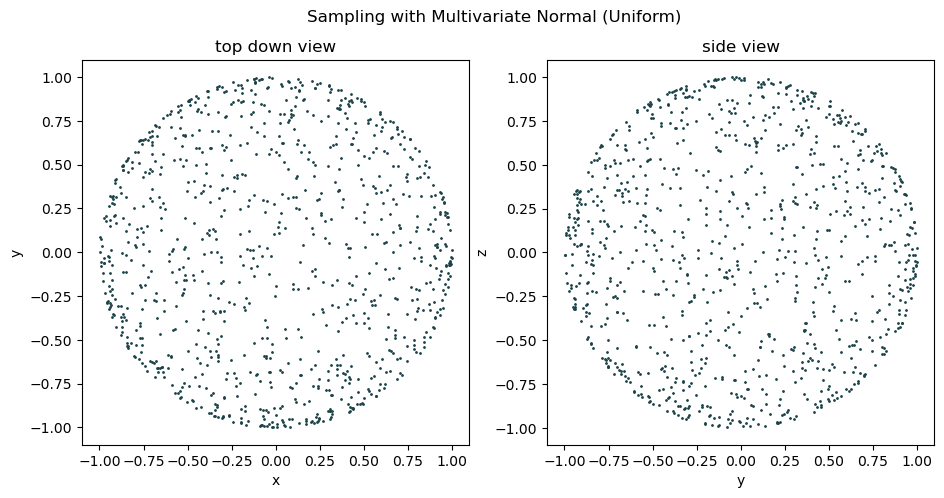

In [66]:
D = 3
N = 10**D

# sample from gaussian distribution
v = np.random.multivariate_normal(np.zeros(3), np.identity(3), size=N)

# normalize
v = v / np.linalg.norm(v, axis=1, keepdims=True)
# Extract Cartesian corrdinate
x, y, z = v[:, 0], v[:, 1], v[:, 2]

# plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 5))
fig.suptitle('Sampling with Multivariate Normal (Uniform)')
ax1.scatter(x, y, s=1)
ax1.set_title('top down view')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax2.scatter(x, z, s=1)
ax2.set_title('side view')
ax2.set_xlabel('y')
ax2.set_ylabel('z')
plt.show()

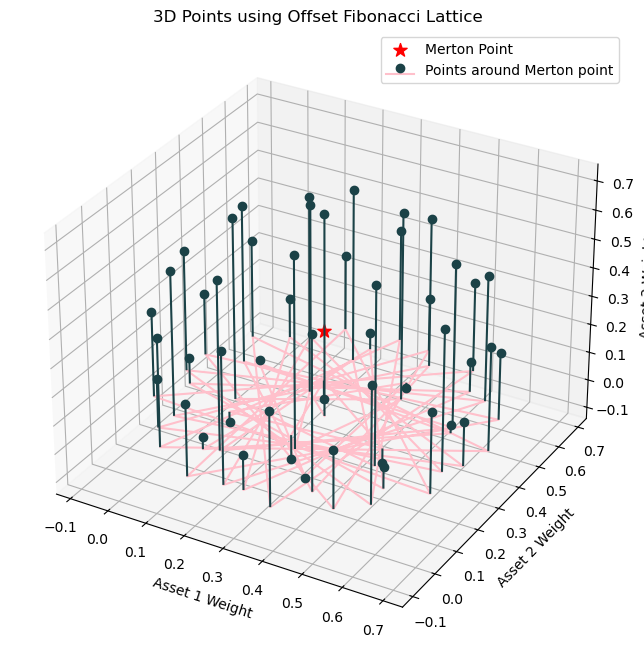

In [65]:
# Re-define the necessary imports and functions after reset

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Function to generate points on an N-sphere using Offset Fibonacci Lattice (works best for 3D)
def generate_offset_fibonacci_nsphere(merton_point, radius, num_points):
    """
    Generates points on the surface of a 3D sphere around the Merton point using Offset Fibonacci Lattice.
    
    :param merton_point: Coordinates of the Merton point (array-like of length 3)
    :param radius: Radius of the 3D sphere
    :param num_points: Number of points to generate
    :return: Array of points (each point is of length 3) on the surface of the sphere
    """
    # Golden ratio
    phi_golden_ratio = (1 + np.sqrt(5)) / 2
    
    # Create arrays for x, y, z coordinates
    indices = np.arange(0, num_points)
    theta = 2 * np.pi * indices / phi_golden_ratio**2  # Azimuthal angle
    z = 1 - 2 * indices / num_points  # Linearly spaced points for z-coordinates (height)
    r = np.sqrt(1 - z**2)  # Radius at each height
    
    # Convert spherical coordinates to Cartesian coordinates
    x = radius * r * np.cos(theta) + merton_point[0]
    y = radius * r * np.sin(theta) + merton_point[1]
    z = radius * z + merton_point[2]
    
    return np.vstack([x, y, z]).T

# Function to plot circle in 3D
def plot_circle_3d(x, y, z, merton_point):
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')
    # ax.scatter(x, y, z, label='Points around Merton point')
    # ax.stem(x, y, z, label='Points around Merton point')
    ax.stem(x, y, z, label='Points around Merton point')
    ax.scatter(*merton_point,marker='*', color='red', label='Merton Point',s=100)
    ax.set_xlabel('Asset 1 Weight')
    ax.set_ylabel('Asset 2 Weight')
    ax.set_zlabel('Asset 3 Weight')
    ax.set_title('3D Points using Offset Fibonacci Lattice')
    ax.legend()
    plt.show()

# Example usage for 3D
merton_point_3d = [0.3, 0.3, 0.3]  # Merton point in 3D
radius = 0.4
num_points = 50

fibonacci_points_3d = generate_offset_fibonacci_nsphere(merton_point_3d, radius, num_points)

# Split the result into x, y, and z for plotting in 3D
x_fibonacci_nsphere, y_fibonacci_nsphere, z_fibonacci_nsphere = fibonacci_points_3d[:, 0], fibonacci_points_3d[:, 1], fibonacci_points_3d[:, 2]
plot_circle_3d(x_fibonacci_nsphere, y_fibonacci_nsphere, z_fibonacci_nsphere, merton_point_3d)

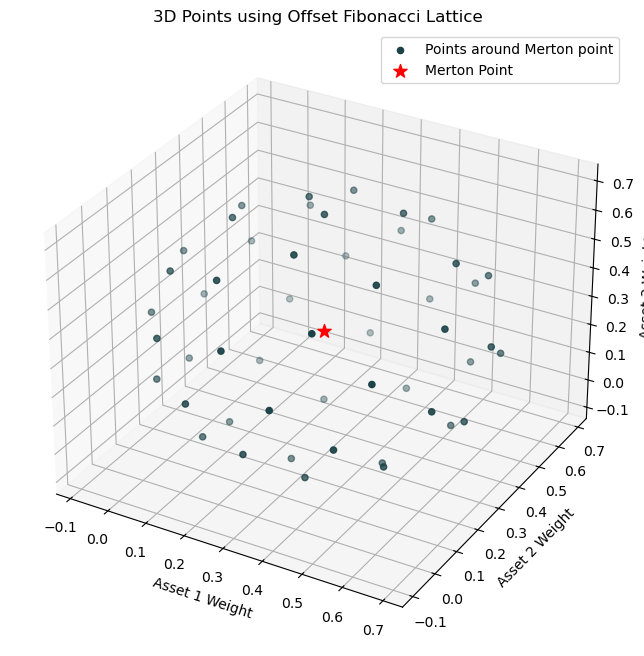

In [63]:
# Function to plot just the points in 3D without connecting them
def plot_points_3d(x, y, z, merton_point):
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(x, y, z, label='Points around Merton point')
    ax.scatter(*merton_point,marker='*', color='red', label='Merton Point',s=100)
    ax.set_xlabel('Asset 1 Weight')
    ax.set_ylabel('Asset 2 Weight')
    ax.set_zlabel('Asset 3 Weight')
    ax.set_title('3D Points using Offset Fibonacci Lattice')
    ax.legend()
    plt.show()

# Plot the points
plot_points_3d(x_fibonacci_nsphere, y_fibonacci_nsphere, z_fibonacci_nsphere, merton_point_3d)